# Table of Contents

- [Goal](#Goal)
- [Wrangle](#Wrangle)
- [Explore Data Analysis (EDA)](#EDA)
  - [Gender](#Gender)
  - [Visualizations](#Visualizations)
    - [Continious Variables](#Continious-Variables)
    - [Catagorical Variables](#Catagorical-Variables)
  - [Hypothesis Testing](#Hypothesis-Testing)
- [Modeling](#Modeling)
- [Results and Conclusions](#Results-and-Conclusions)
  - [Next Steps](#Next-Steps)
- [Appendix](#Appendix)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import scipy.stats as stats
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from wranglev2 import wrangle_credit, create_scaled_x_y

import warnings
warnings.filterwarnings("ignore")
print('Initialized')

Initialized


# Goal

Chinese banks are very risk-averse, yet younger generations are more willing to take on debt at similar rates to other developed countries. What are the contributing factors to a credit card holder defaulting on debt? When will an account default 6 months into the future? That is what we aim to find out! We will accomplish this by looking for patterns in a user's credit history and application data, always with an eye to ethical consideration when dealing with demographic data, to predict if they will default 6 months in the future. 

**Bottom Line Up Front (BLUF)**

From all the work contained in this notebook we have determined that...

---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

# Wrangle

All the prep/wrangle work is handled by the wrangle_credit function imported above. For an indpeth explination of how the wrangle_credit function works please see the [How-To Notebook](https://github.com/credit-risk-management-predictor/credit-risk-management-predictor/blob/main/how_to.ipynb).


In [2]:
help(wrangle_credit)

Help on function wrangle_credit in module wranglev2:

wrangle_credit()
    This function does the following:
    * uses get_reports_data function to process credit_reports.csv data into the expanded DF 
    * uses get_application_data functionto process the application_record.csv into an apps DF
    * uses encode_dummies function to create dummy variables from the categorical variables of the apps DF
    * merges the apps and expanded DFs into a final_df on 'id'
    * uses split_stratify_data on the final_df to create the train, validate, test data sets
    * return train, validate, test data sets as DFs
    Note - The create_scaled_x_y function will be used after EDA to avoid confusion.
    Note 2 - Remember to drop columns not used as features such as age, gender, etc



In [3]:
train, validate, test = wrangle_credit()
train.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,...,first_half_score,difference_score,odds_evens_score,begining_score,middle_score,ending_score,spread_score,alpha_omgea_score,begining_ending_score,defaulted
22151,5142128,F,0,0,0,283500.0,Commercial associate,Secondary / secondary special,Married,Municipal apartment,...,0,0,0,0,0,0,0,0,0,0
21572,5136981,F,0,0,0,306000.0,State servant,Higher education,Married,House / apartment,...,7,-2,9,4,6,2,9,3,6,0
8328,5052719,F,0,0,0,126000.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,3,0,4,2,2,2,4,2,4,0
19787,5117901,F,0,0,0,76500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,...,3,0,4,2,2,2,4,2,4,0
12424,5069147,M,0,1,0,216000.0,Commercial associate,Higher education,Married,House / apartment,...,2,-1,3,2,0,1,0,3,3,0


**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

# EDA

When dealing with something as consequential as credit card approvals, it is important to make sure you aren't training your model with data that has been biased against a demographic class due to historical discrimination as this can reinforce cultural biases. Besides, it's also bad for business. Knowing this, we will begin by determining if ***gender*** can be inferred from other information within the application data. 

After we explore if gender can be inferred from other information, we will then explore the rest of the data by visualizing it. We will then conduct [hypothesis testing](#Hypothesis-Testing) on any [insightful visualization](#Insightful-Visualizations)  in order to determine which to use in modeling.

---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

## Gender

In order to determine whether or not gender can be inferred from our data we have to conduct hypothesis tests. We will cross reference gender with the following features:

> flag_own_car, flag_own_realty, cnt_children, amt_income_total,

We accomplished this by running Two-Sample; Two-Tail T-tests and found that each had a significant statistically relationship with gender. However, while income and gender have a relationship, gender and income may suffer from a third variable problem.  Intuitively, this makes sense as income is also greatly dependent upon occupation. A T-test would show the macro relationship between gender and income, but would not be able to account for other confounding factors. For more details on the gender pay gap, see [The True Story of the Gender Pay Gap](https://freakonomics.com/podcast/the-true-story-of-the-gender-pay-gap-a-new-freakonomics-radio-podcast/) by [Feakonomics Podcast](www.freakonomics.com).

Next, we continue on with our EDA by exploring [other variables](#Visualizations) relationship with 'defaulted.'

---
**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

In [4]:
train.code_gender.value_counts()

F    11730
M     5903
Name: code_gender, dtype: int64

Text(0.5, 0, 'Number of Applicants')

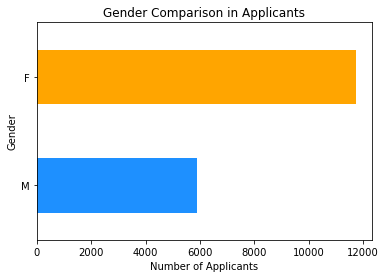

In [5]:
train.code_gender.value_counts().sort_values().plot(kind = 'barh', color = ['dodgerblue', 'orange'])
plt.title('Gender Comparison in Applicants')
plt.ylabel('Gender')
plt.xlabel('Number of Applicants')

### What are the average default rates between men and women**

In [6]:
# Average default rate amongst males
men = train[train.code_gender == 'M'].defaulted.mean()

# Average default rate amongst females
women = train[train.code_gender == 'F'].defaulted.mean()

print(f"The average default for men is {round(men, 4)}. \nThe average default rate for women is {round(women, 4)}")

The average default for men is 0.0042. 
The average default rate for women is 0.0034


### Is there a relationship between gender and car ownership?

In [7]:
# Average car ownership amongst males
men = train[train.code_gender == 'M'].flag_own_car.mean()

# Average car ownership amongst females
women = train[train.code_gender == 'F'].flag_own_car.mean()

print(f"The average car ownership for men is {round(men, 4)}. \nThe average default rate for women is {round(women, 4)}")



The average car ownership for men is 0.651. 
The average default rate for women is 0.2596


In [8]:
alpha = 0.05
stat, p = stats.ttest_ind(train[train.code_gender == 'M'].flag_own_car, train[train.code_gender == 'F'].flag_own_car)

if p < alpha:
    print('We reject the null hypothesis. Based on t-statistic, males own cars at a higher rate than females.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Based on t-statistic, males own cars at a higher rate than females.


### Is there a relationship between gender and realty ownership?

In [9]:
# Average home ownership amongst males
men = train[train.code_gender == 'M'].flag_own_realty.mean()

# Average home ownership amongst females
women = train[train.code_gender == 'F'].flag_own_realty.mean()

print(f"The average realty ownership rate for men is {round(men, 4)}. \nThe average realty ownership rate for women is {round(women, 4)}")

The average realty ownership rate for men is 0.6143. 
The average realty ownership rate for women is 0.6738


Males appear to own cars at a higher rate than females. We can validate this observation with a t-test:

$H_0$: There is no difference in car ownership rates among males and females.  
$H_0$: There is a difference in car ownership rates among males and females.

In [10]:
alpha = 0.05
stat, p = stats.ttest_ind(train[train.code_gender == 'M'].flag_own_car, train[train.code_gender == 'F'].flag_own_car)
stat, p

if p < alpha:
    print('We reject the null hypothesis. Based on t-statistic, males have more children than females.')
else:
    print('We fail to reject the null hypothesis.')   

We reject the null hypothesis. Based on t-statistic, males have more children than females.


### Is there a relationship between gender and the number of children?

In [11]:
# Average number of children amongst males
men = train[train.code_gender == 'M'].cnt_children.mean()

# Average number of children amongst females
women = train[train.code_gender == 'F'].cnt_children.mean()

print(f"The average number of children for men is {round(men, 2)}. \nThe average number of children for women is {round(women, 2)}")

The average number of children for men is 0.53. 
The average number of children for women is 0.38


Male applicants appear to have more children than female applicants. We can validate this with a t-test:

$H_0$: There is no difference in the number of children between males and females  
$H_a$: There is a difference in the number of children between males and females

In [12]:
stat, p = stats.ttest_ind(train[train.code_gender == 'M'].cnt_children, train[train.code_gender == 'F'].cnt_children)
stat, p

if p < alpha:
    print('We reject the null hypothesis. Based on t-statistic, men have more children than females.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Based on t-statistic, men have more children than females.


### Is there a relationship between gender and income?

In [13]:
# Average income amongst males
men = train[train.code_gender == 'M'].amt_income_total.mean()

# Average income amongst females
women = train[train.code_gender == 'F'].amt_income_total.mean()

print(f"The average income for men is {round(men, 2)}. \nThe average income for women is {round(women, 2)}")

The average income for men is 219159.84. 
The average income for women is 173498.37


Male applicants appear to have more higher incomes than female applicants. We can validate this with a t-test:

$H_0$: There is no in income between males and females  
$H_a$: There is a difference in income between males and females

In [14]:
stat, p = stats.ttest_ind(train[train.code_gender == 'M'].amt_income_total, train[train.code_gender == 'F'].amt_income_total)

if p < alpha:
    print('We reject the null hypothesis. Based on t-statistic, males have more income than females.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Based on t-statistic, males have more income than females.


## Visualizations

To gather insights into our data we will split our visualizations into two types: [continuous variables](#Continuous-Variables) and [catagorical variables](#Catagorical-Variables). Based on our previous testing with gender, we decided not to include `flag_own_car`, `flag_own_realty`, or `cnt_children` in our visualization as these were tightly correlated with gender. From these two types of visualizations, we determined that we needed to conduct [hypothesis testing](#Hypothesis-Testing) on the following variables:

**Continuous Variables Finding**
* There is a clear difference between the distributions of defaulted and not defaulted account holders for each of the scoring variables and how many months an account existed in the data
* Defaulted accounts skew toward the higher end of the of the scoring system, ergo they have more instances of late payments on the whole.
* With difference score, the accounts that defaulted have more positive values which means that their scores are higher in months 4, 5, and 6 combined than 1, 2, and 3 combined. 
* With difference score, accounts that did not default appear to have more consistent payments across the months as the majority accounts have a score of 0.


**Categorical Variables Findings**
- People with commercial associate type as income type make of 23% of the total pop however, they make 31% of the default pop
- Income type categorized as student dont default at all
- People with higher education make up 28% of the total applicant, however they make 31% of the total defaulting population
- People with incomplete higher education make up 4% of the total applicant population, however, they make up 6% of the defaulted population.
- People with Academic degree and lower secondary degree dont default at all and 
- Those who stay with parents dont default on their debt
- Those with house/apartment are more likely to default
- Those with office appartment dont default on their debt

---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

### Continuous Variables

> 'total_score', 'odd_months_score', 'last_half_score', 'first_half_score', 'difference_score', 'odds_evens_score', 'begining_score', 'middle_score', 'ending_score', 'spread_score', 'alpha_omgea_score', 'begining_ending_score', 'months_exist'
---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

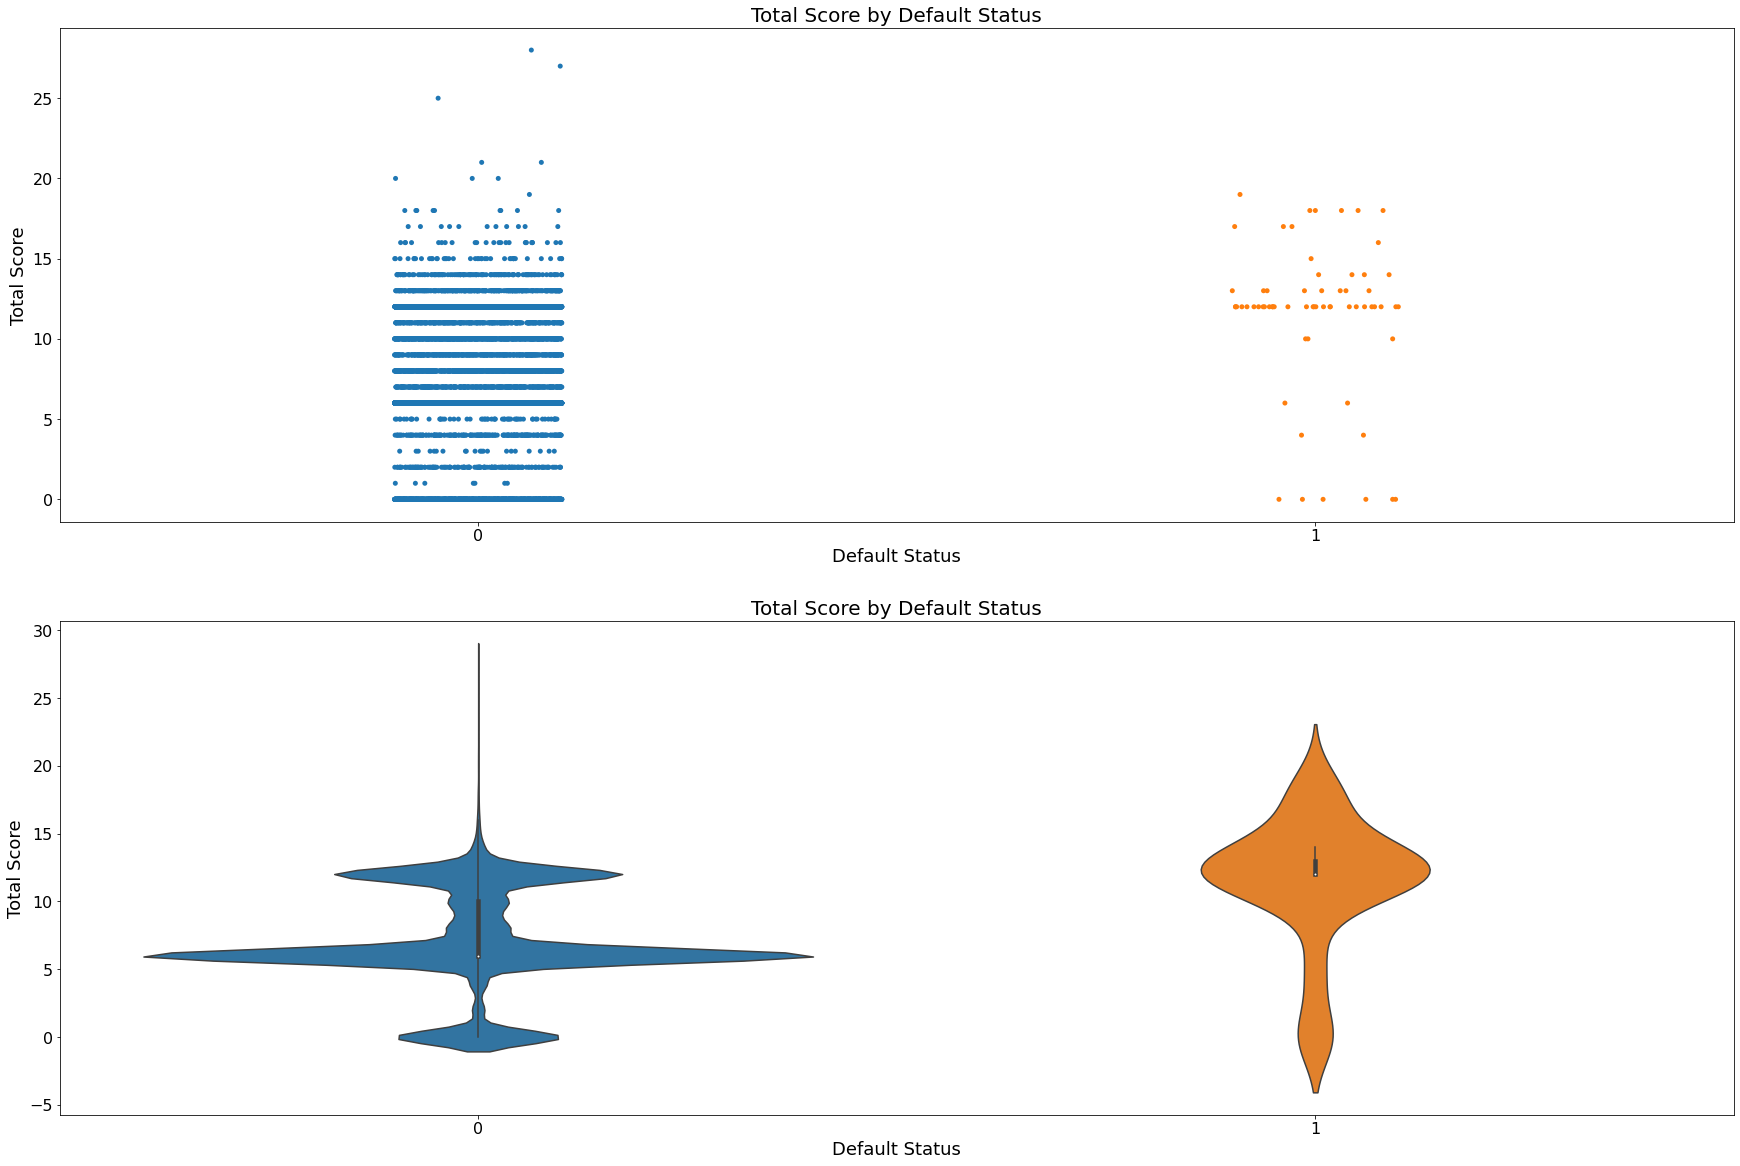

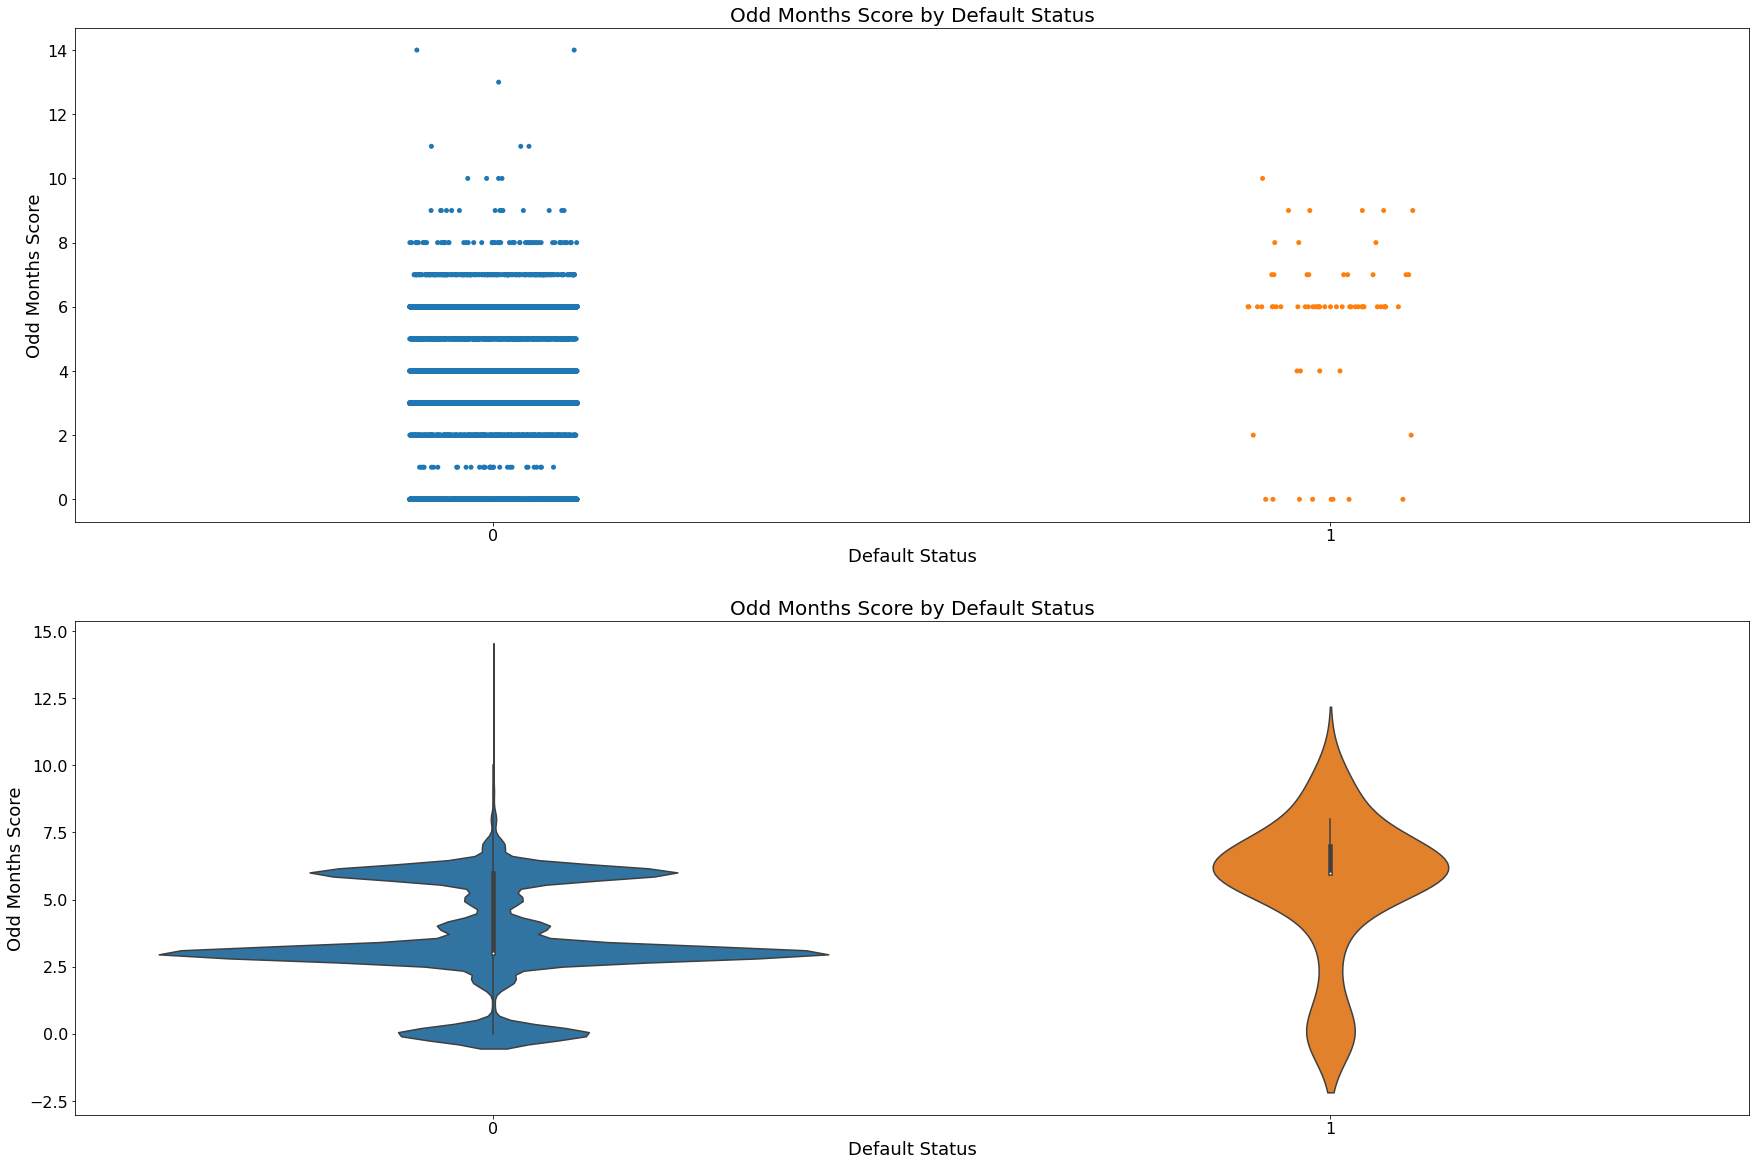

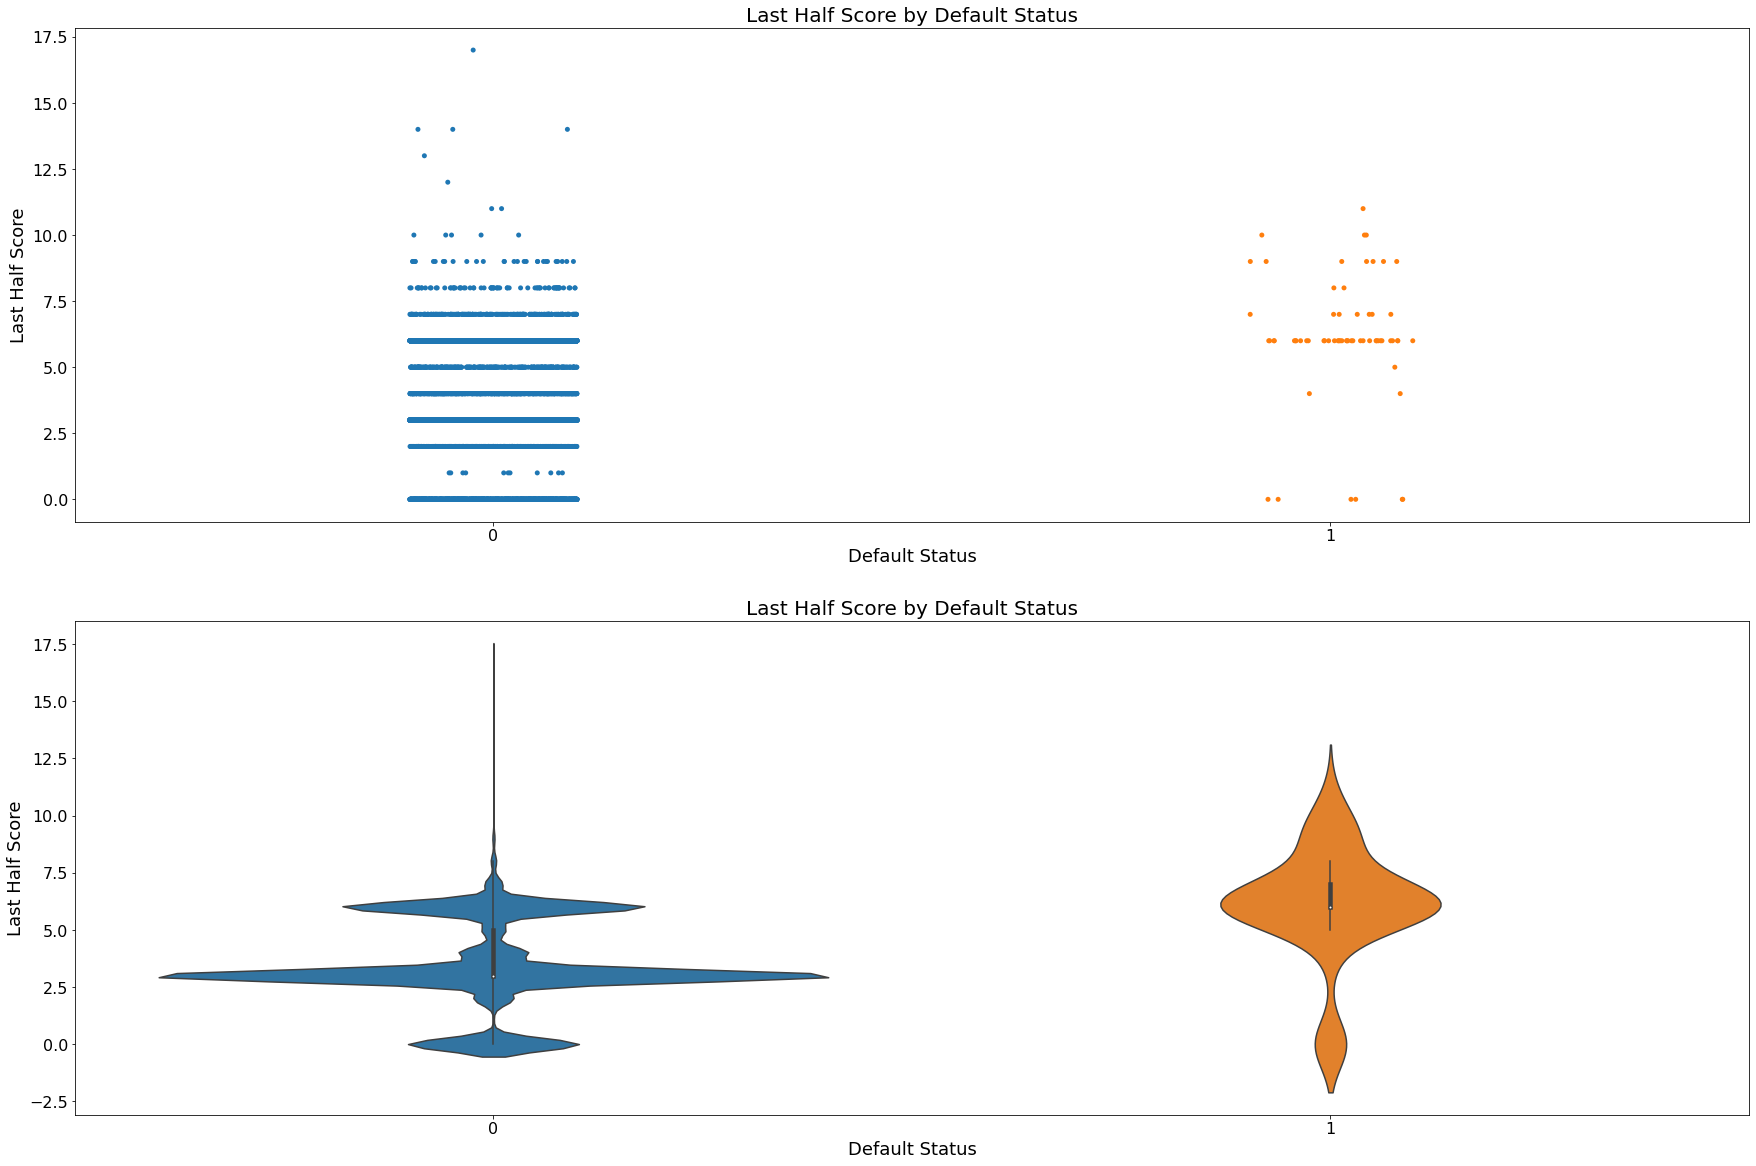

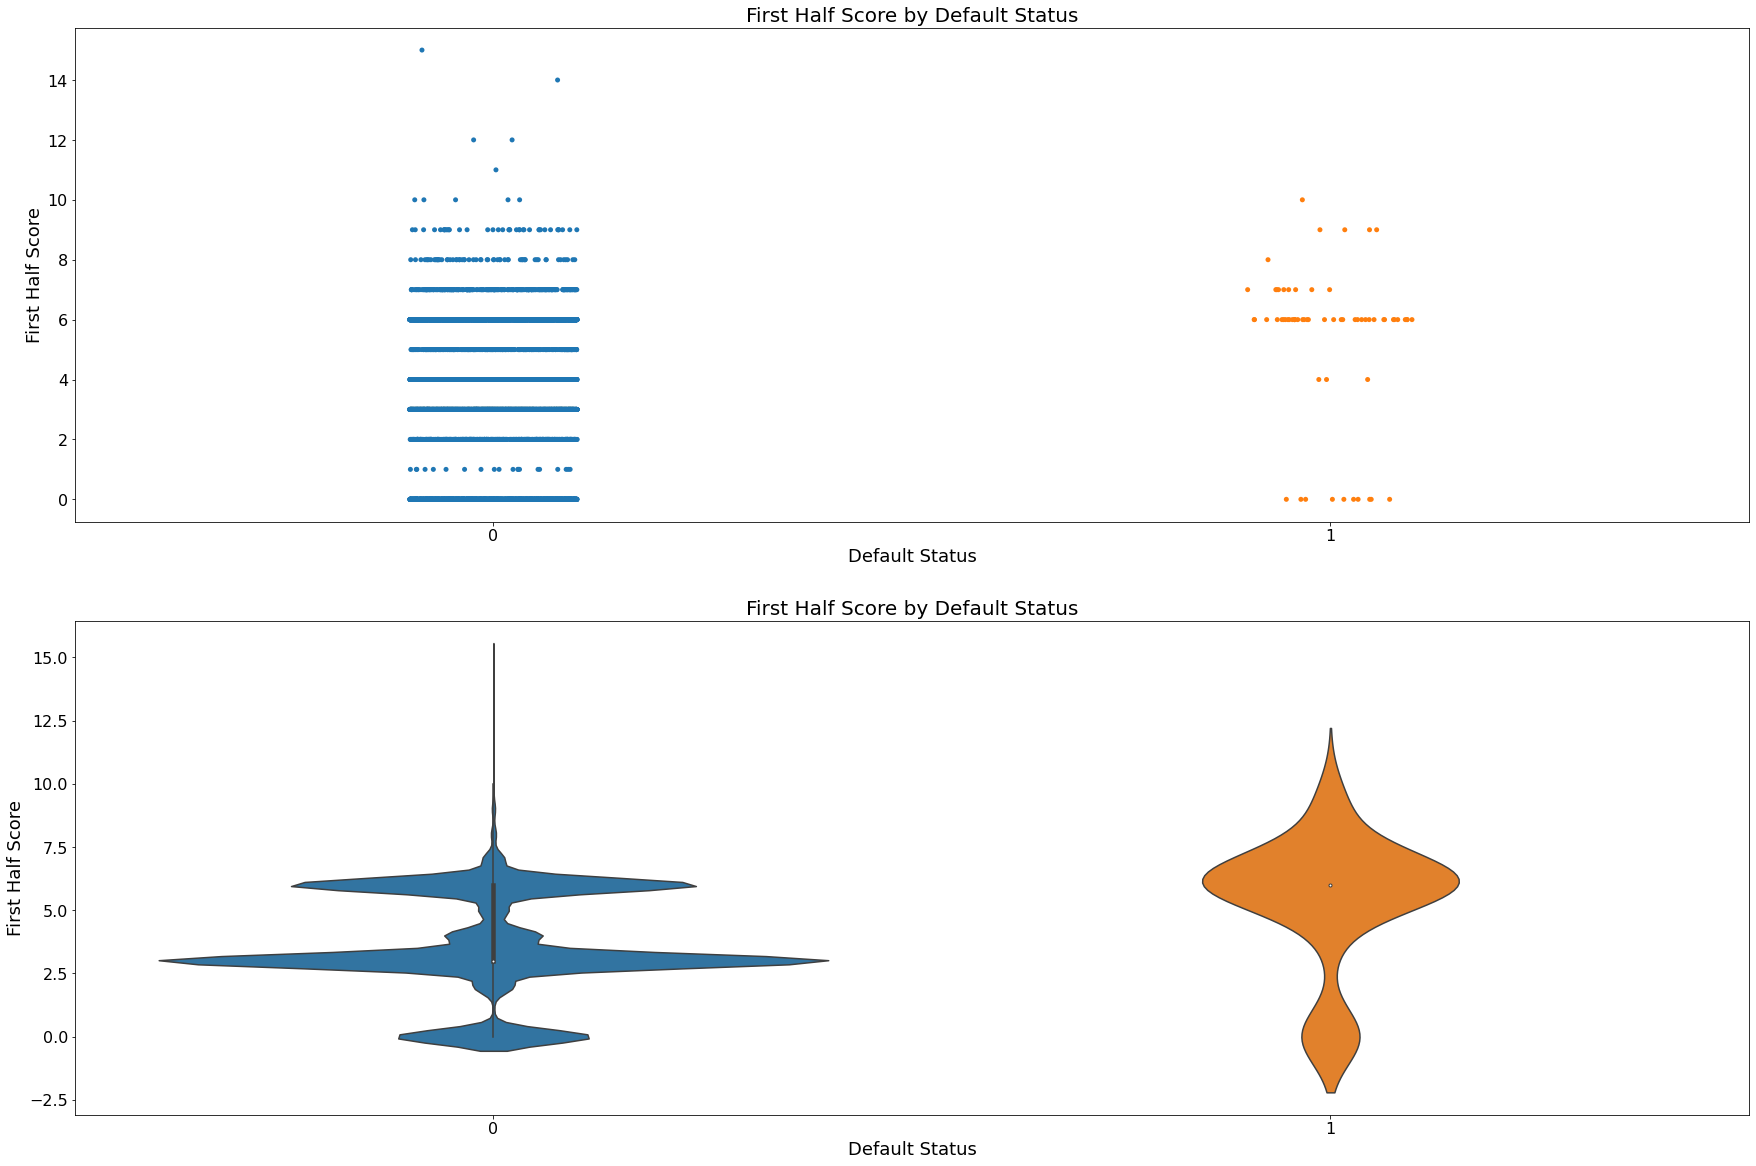

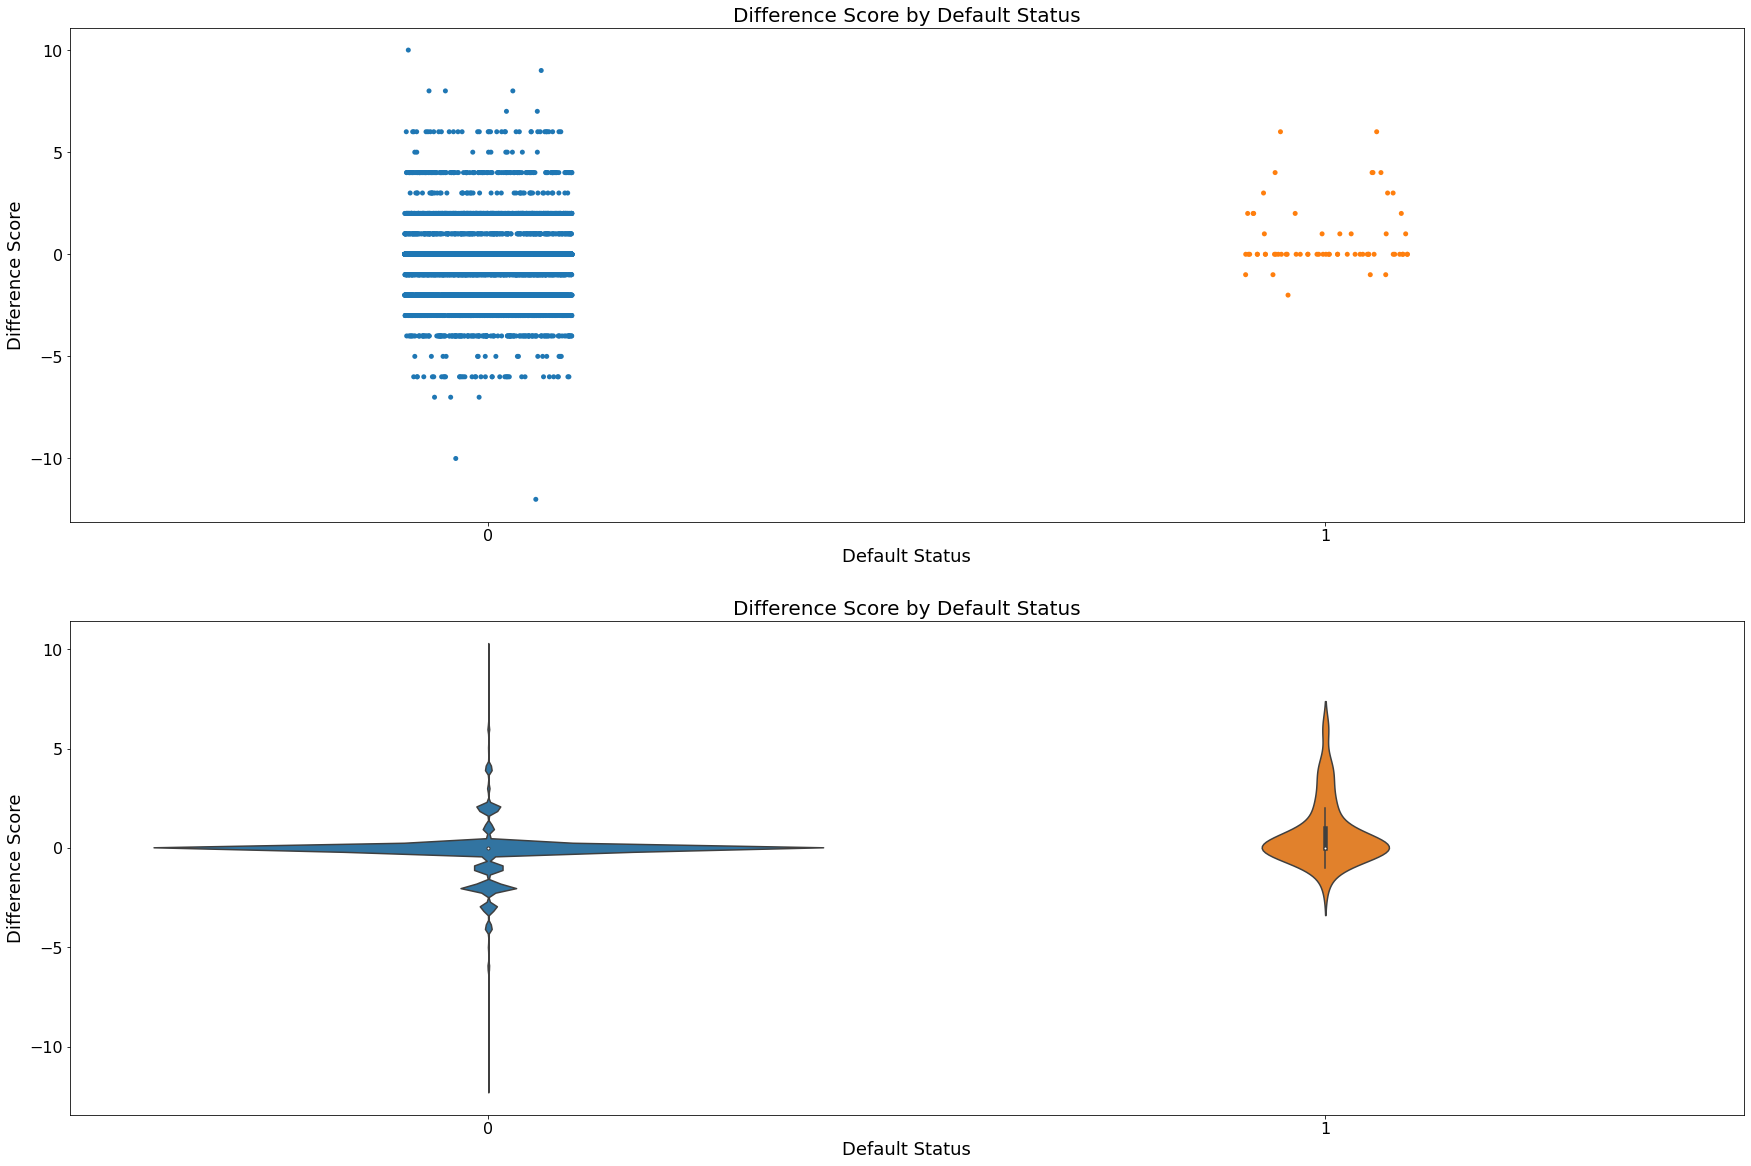

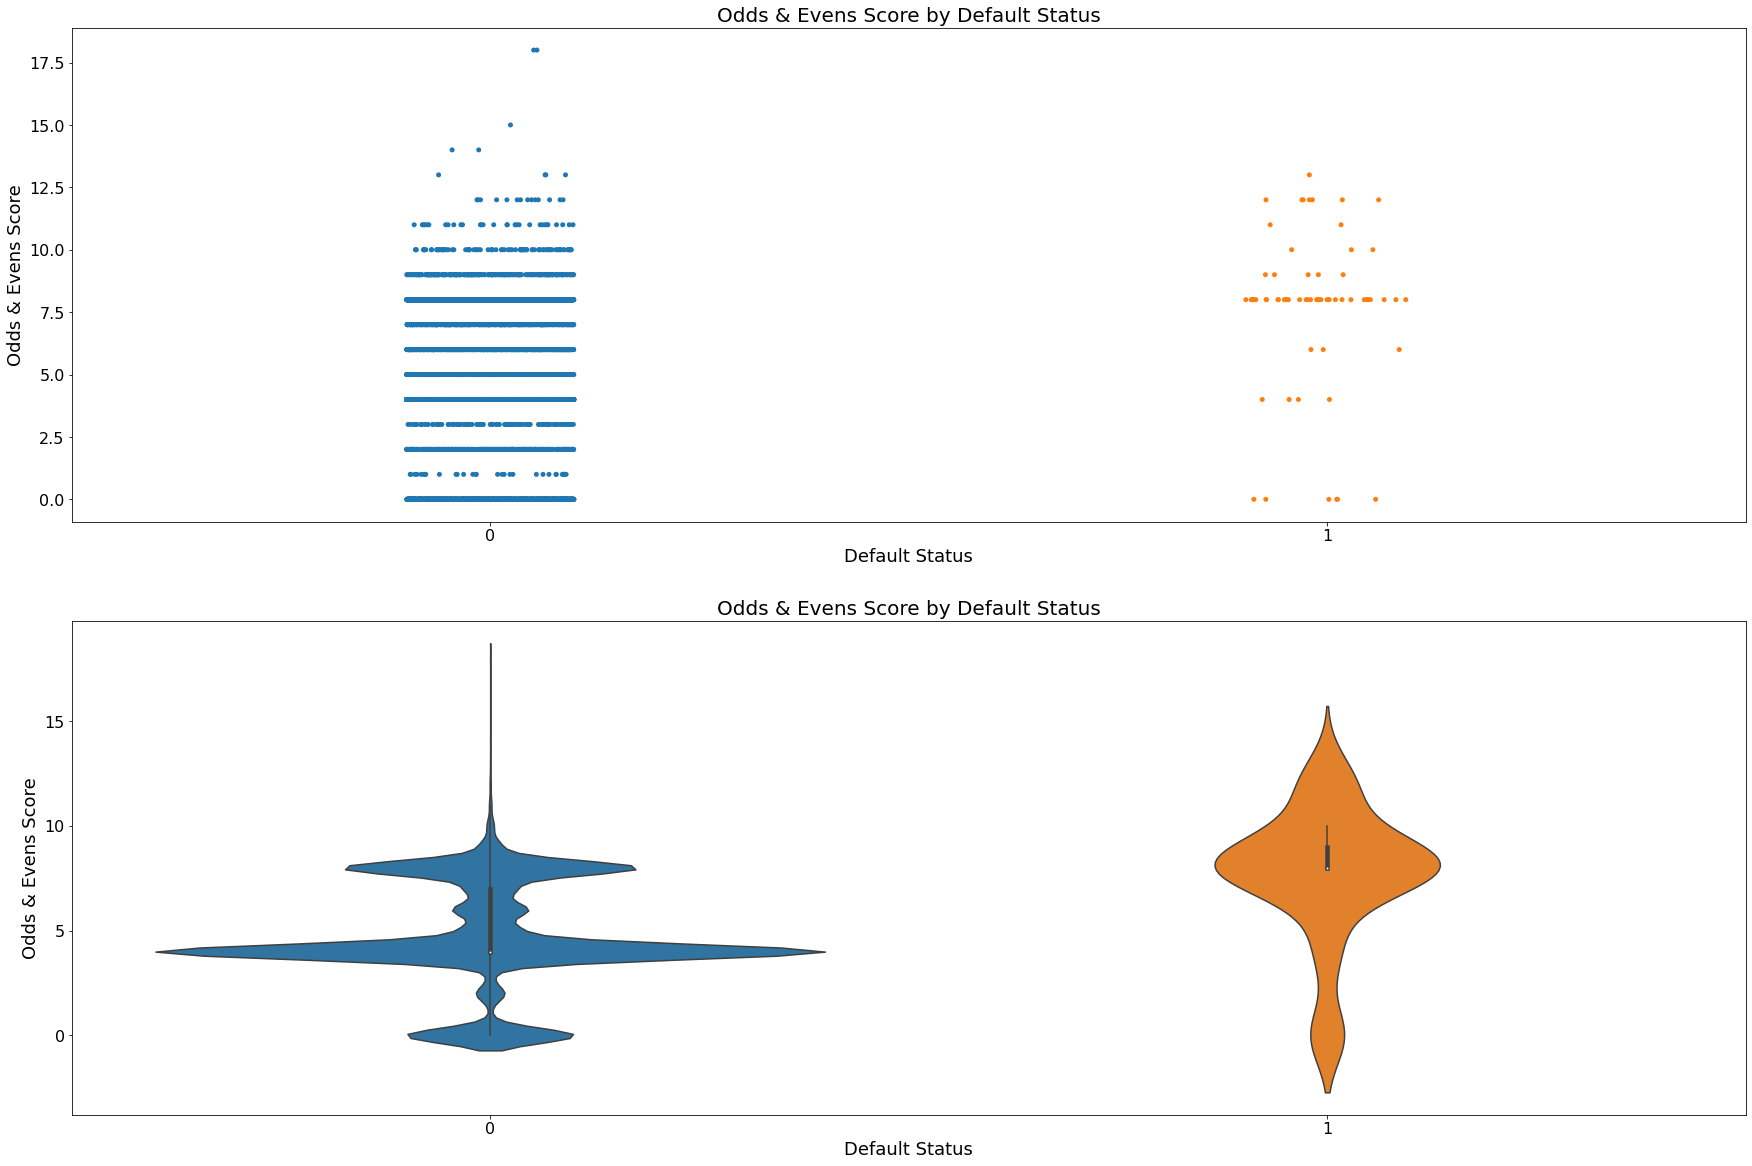

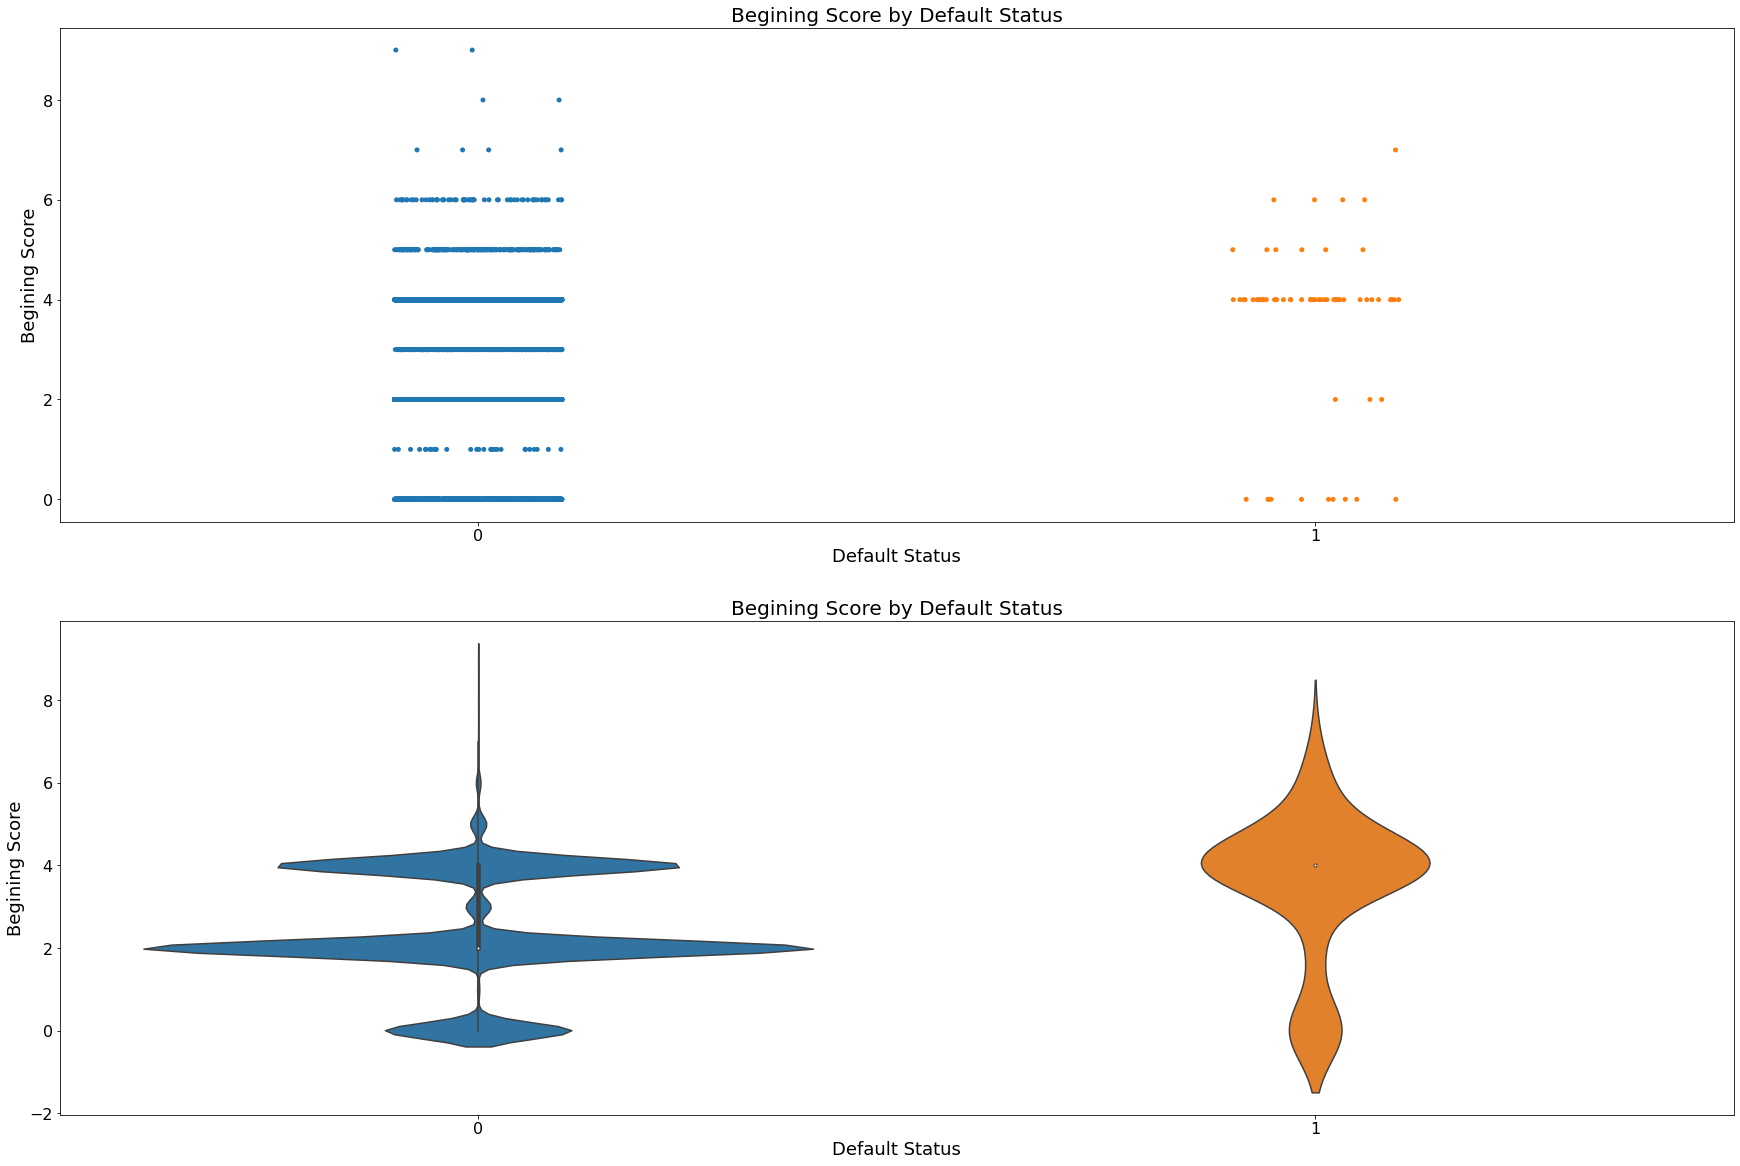

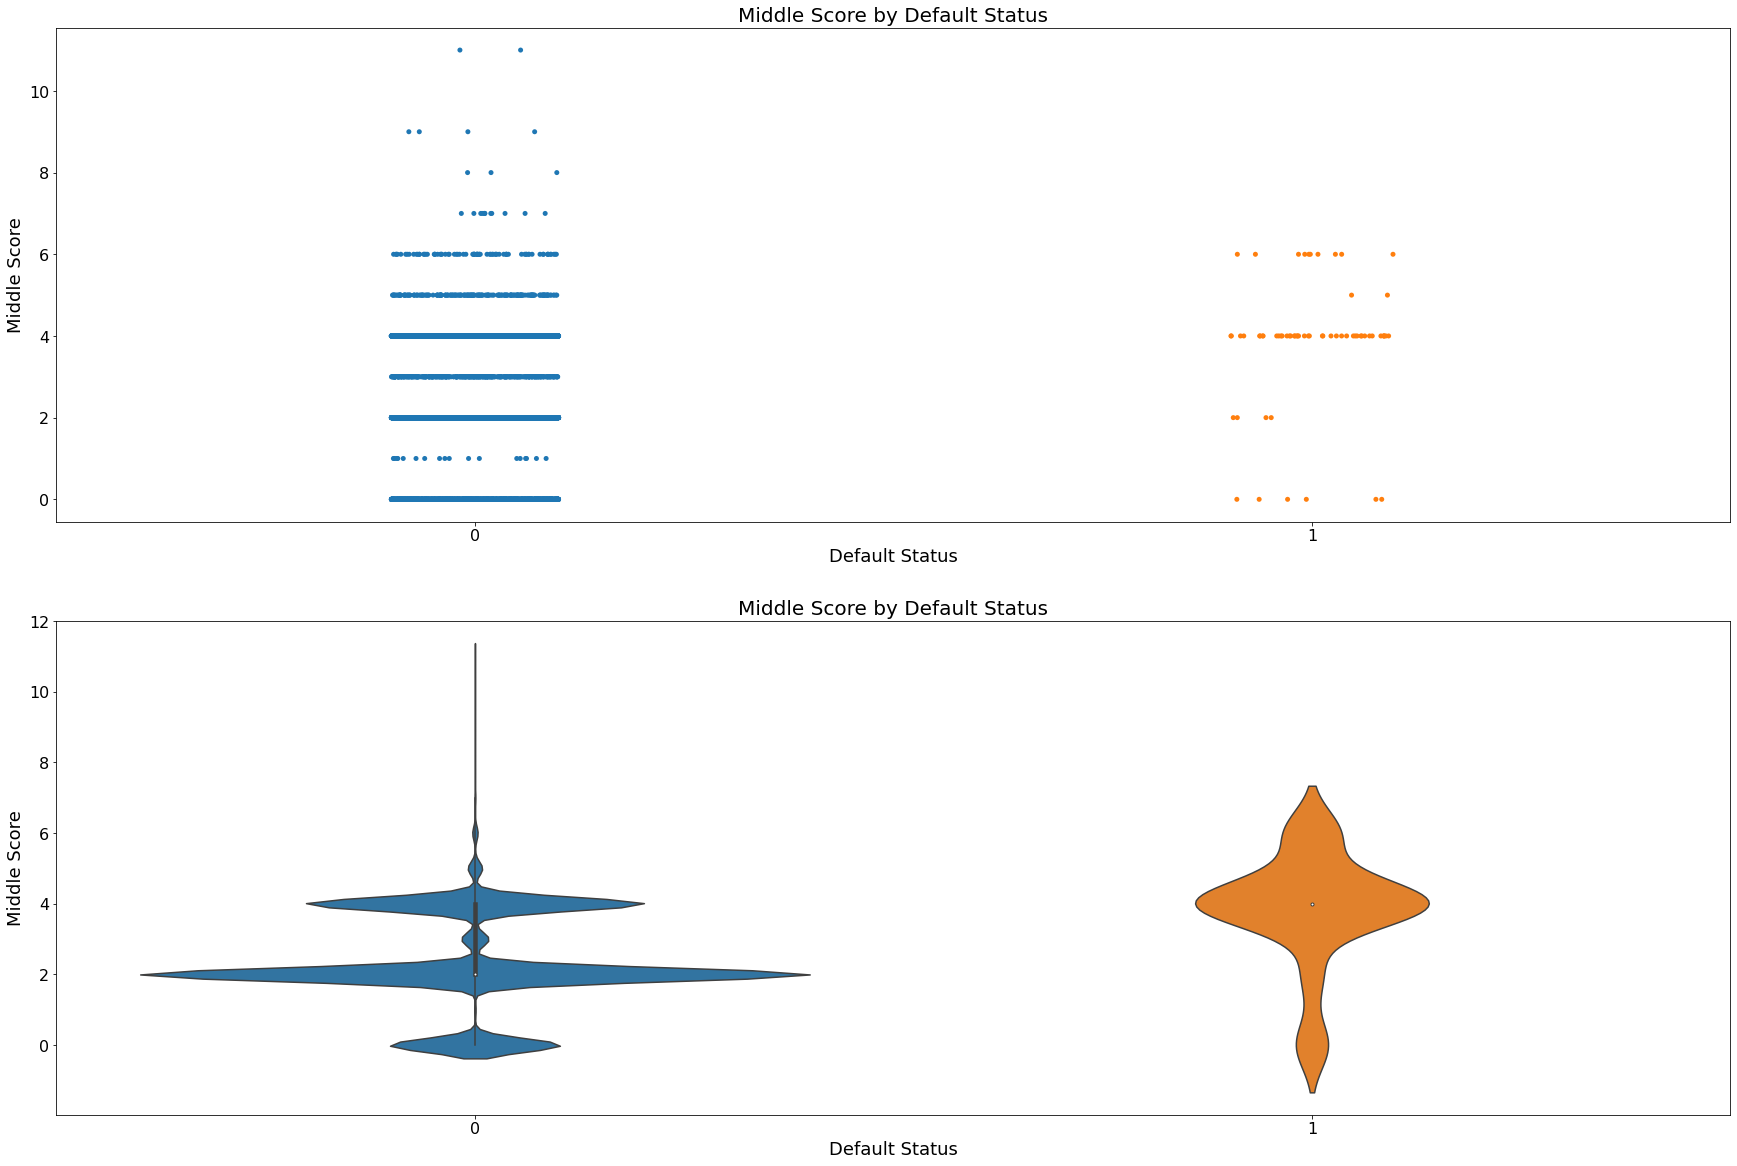

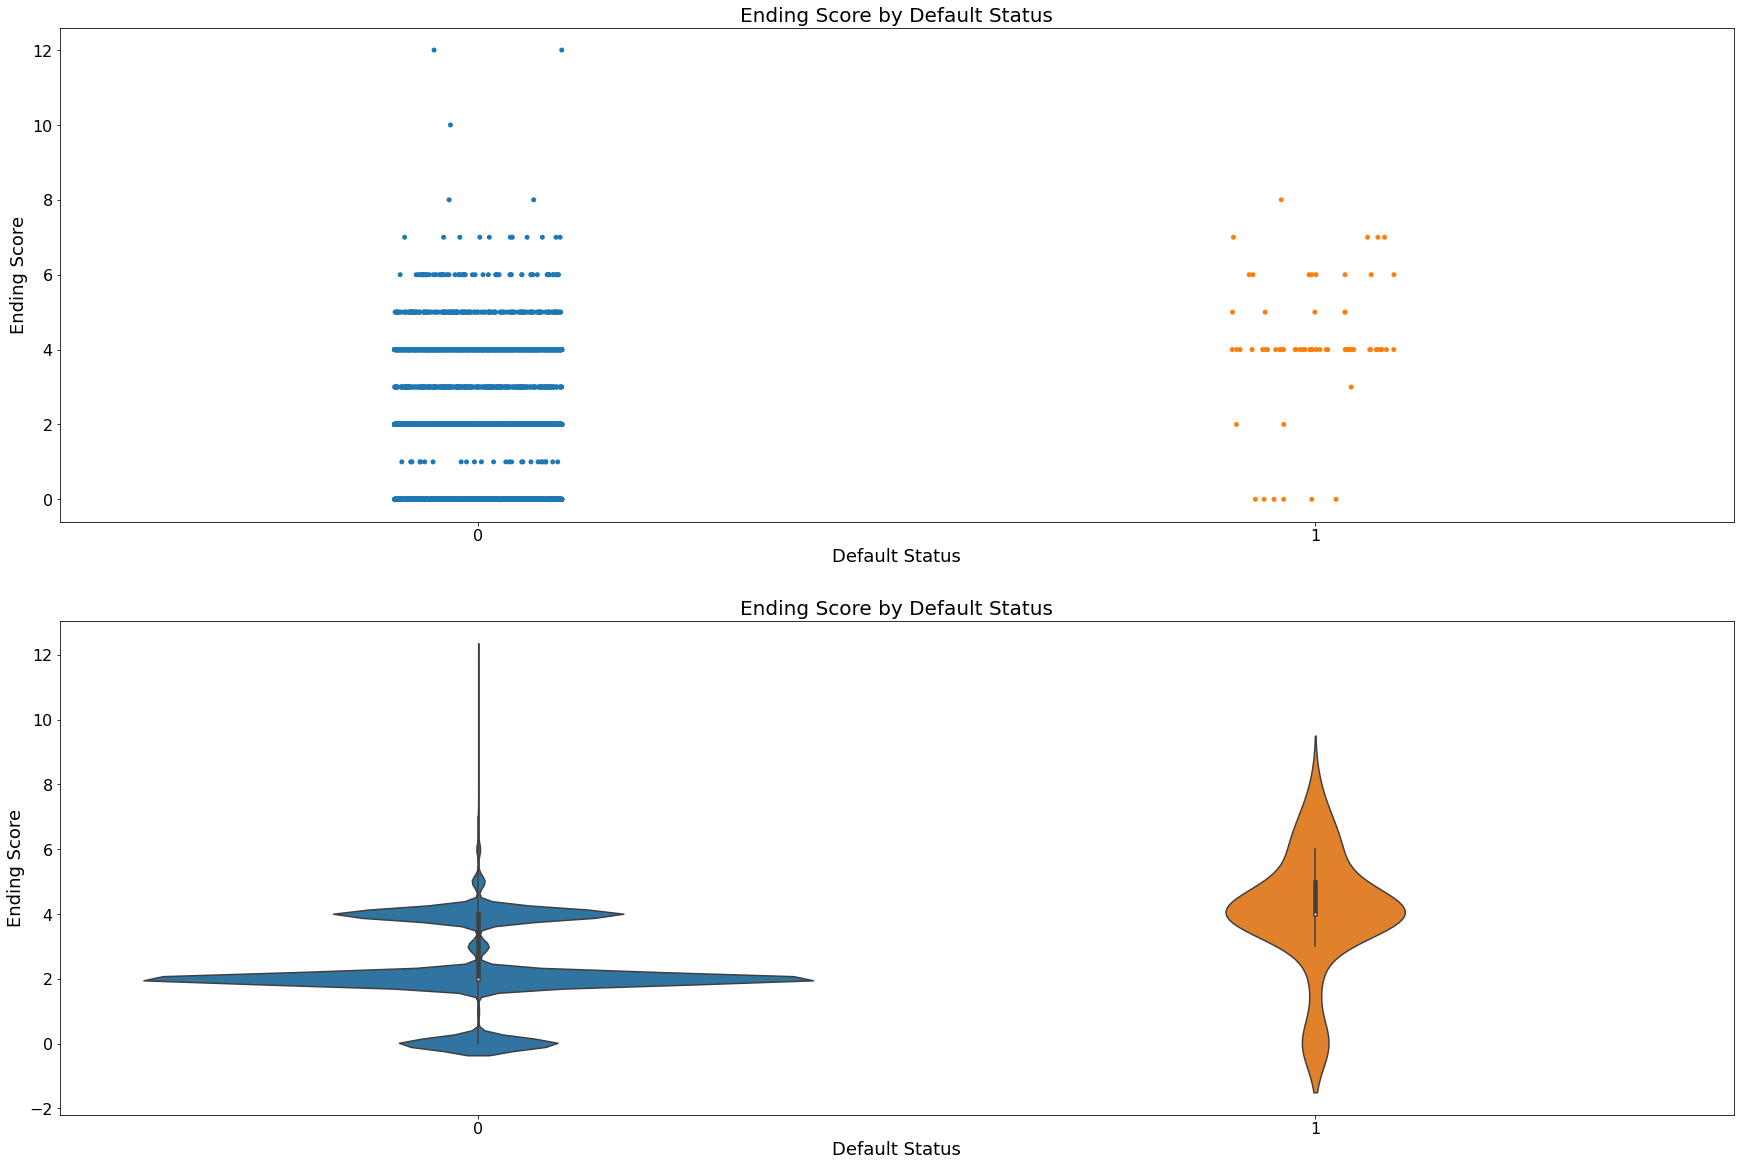

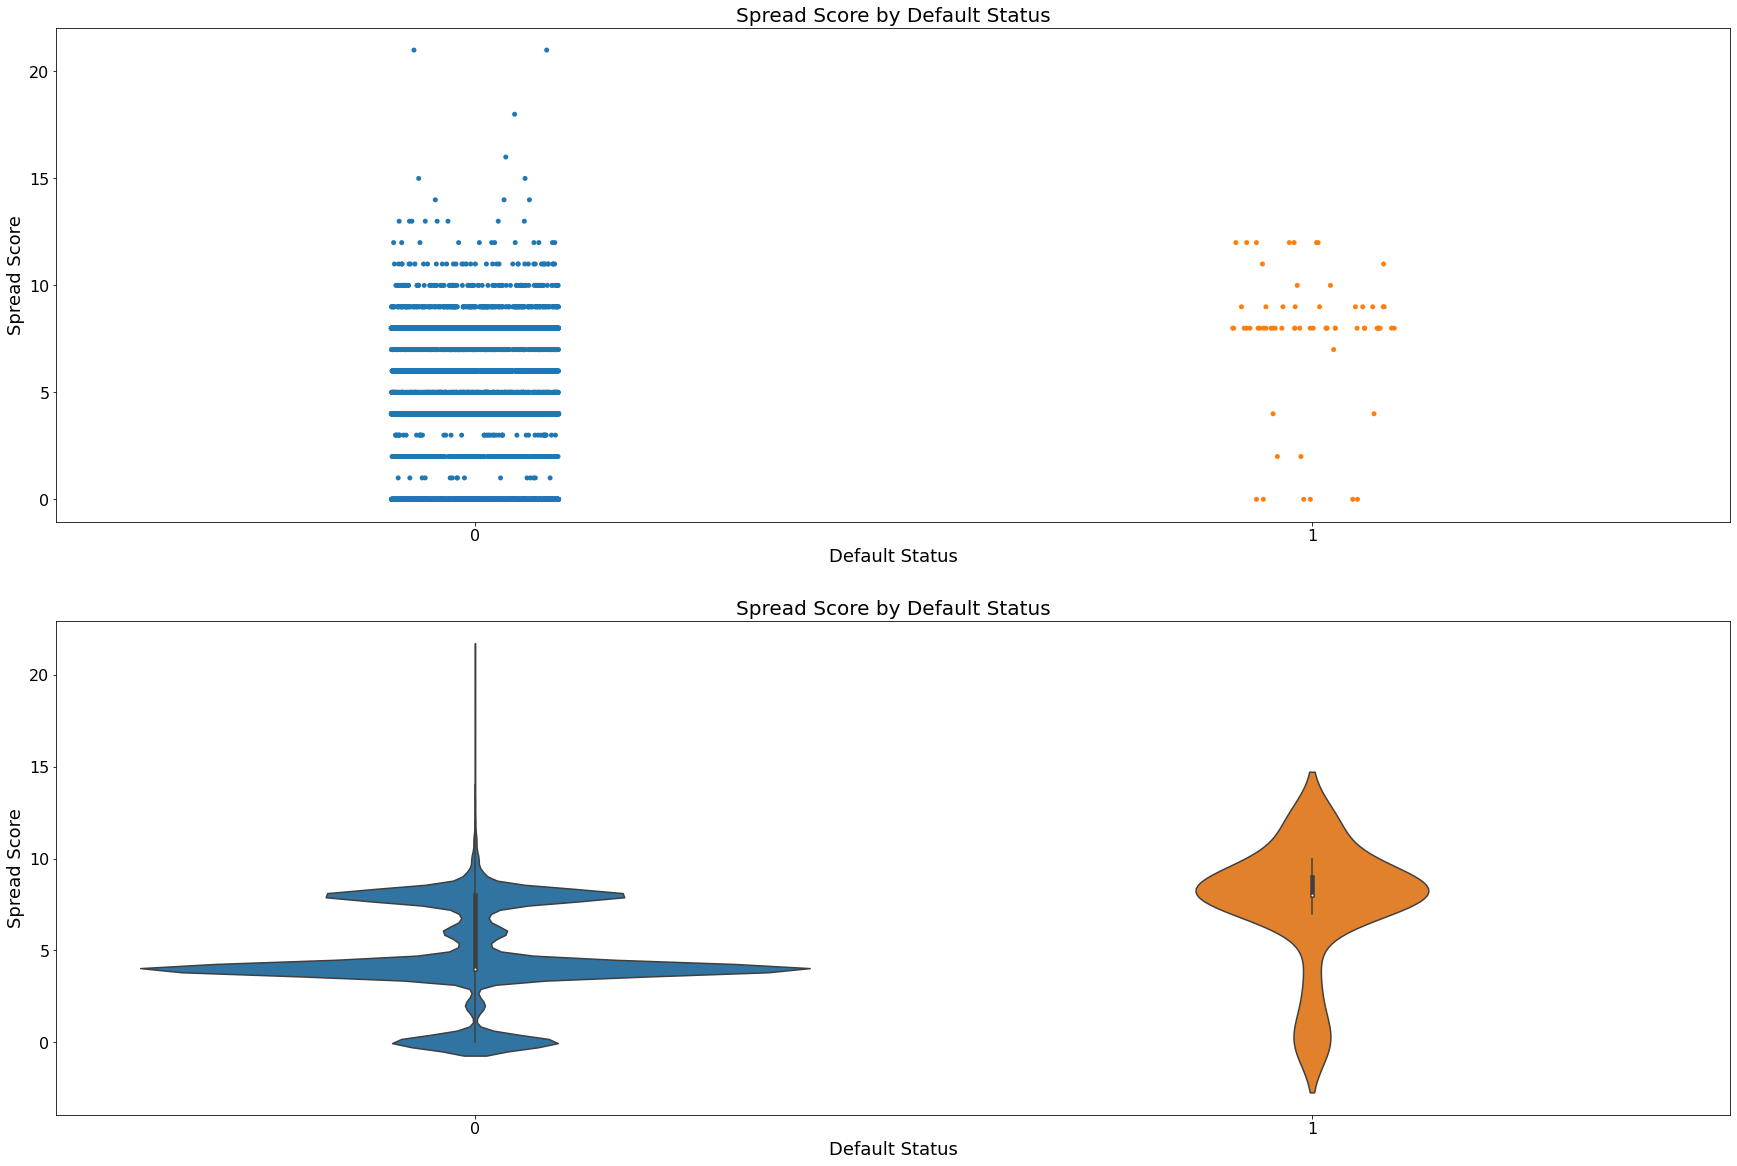

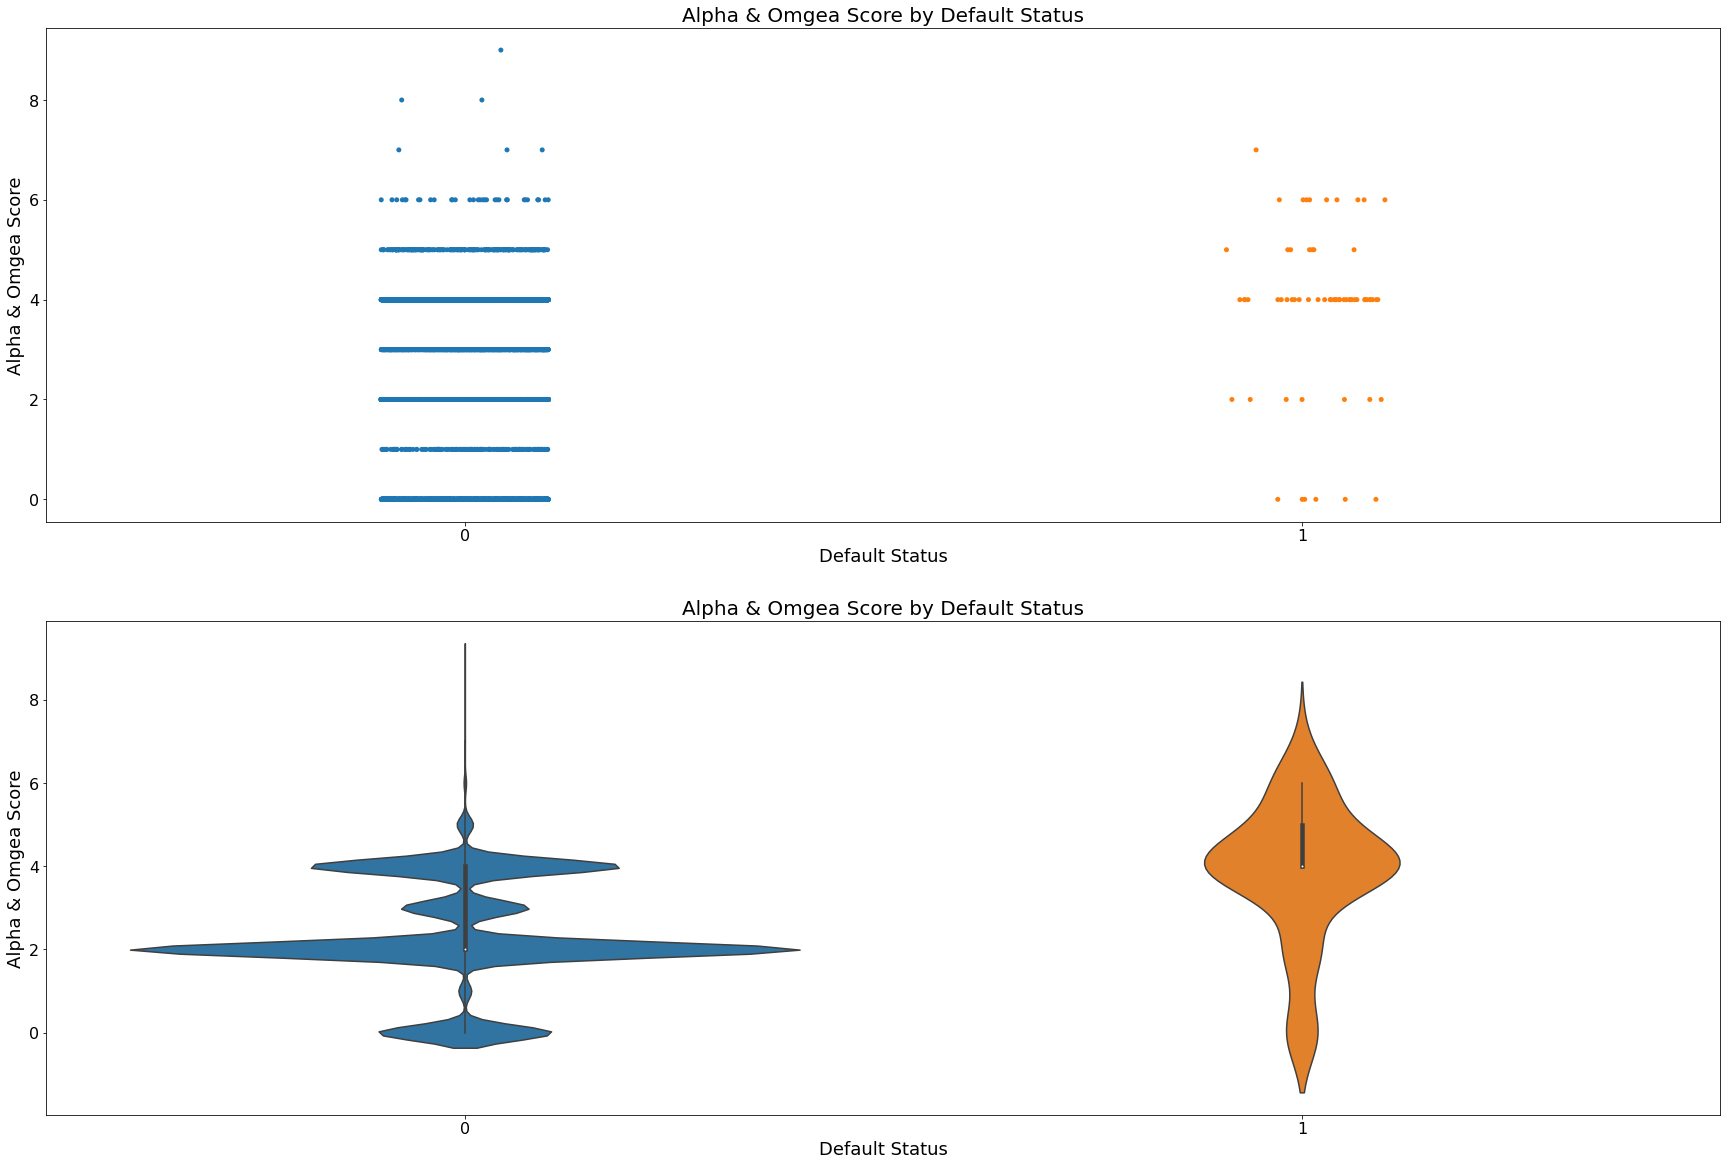

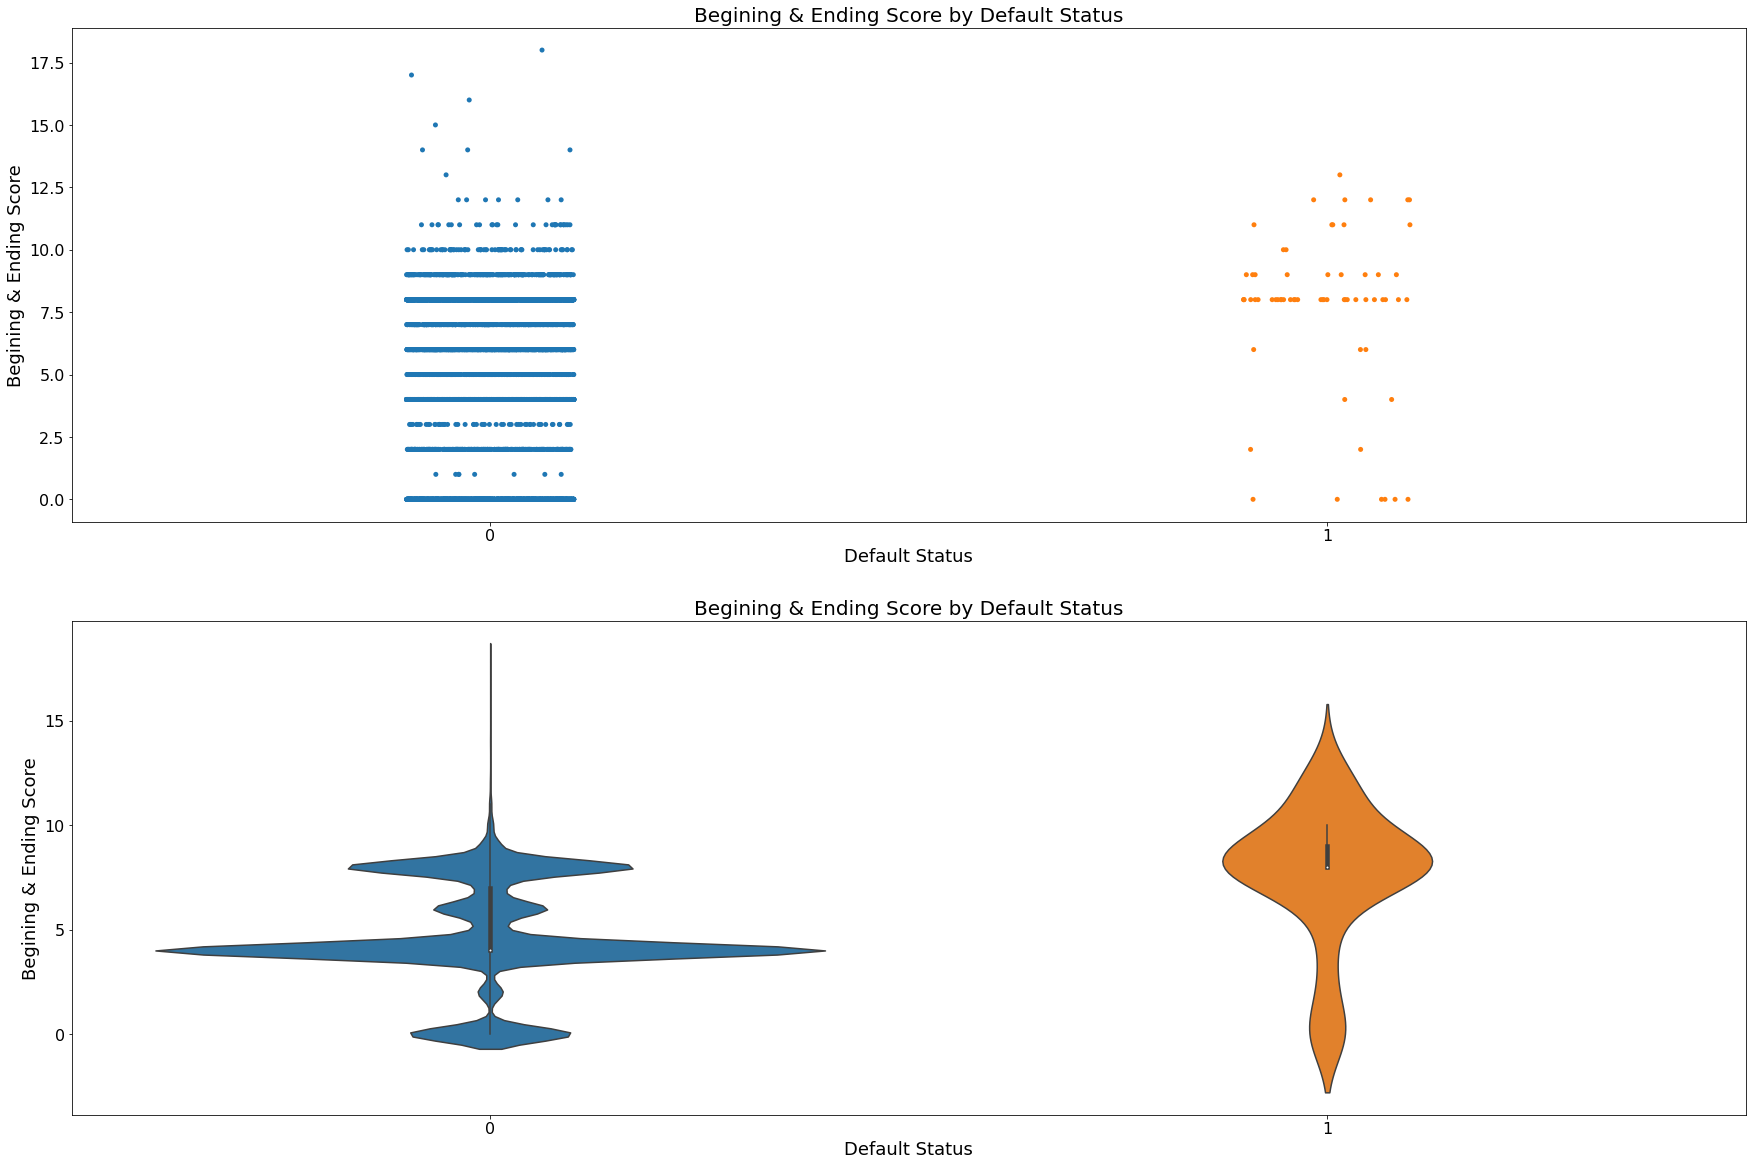

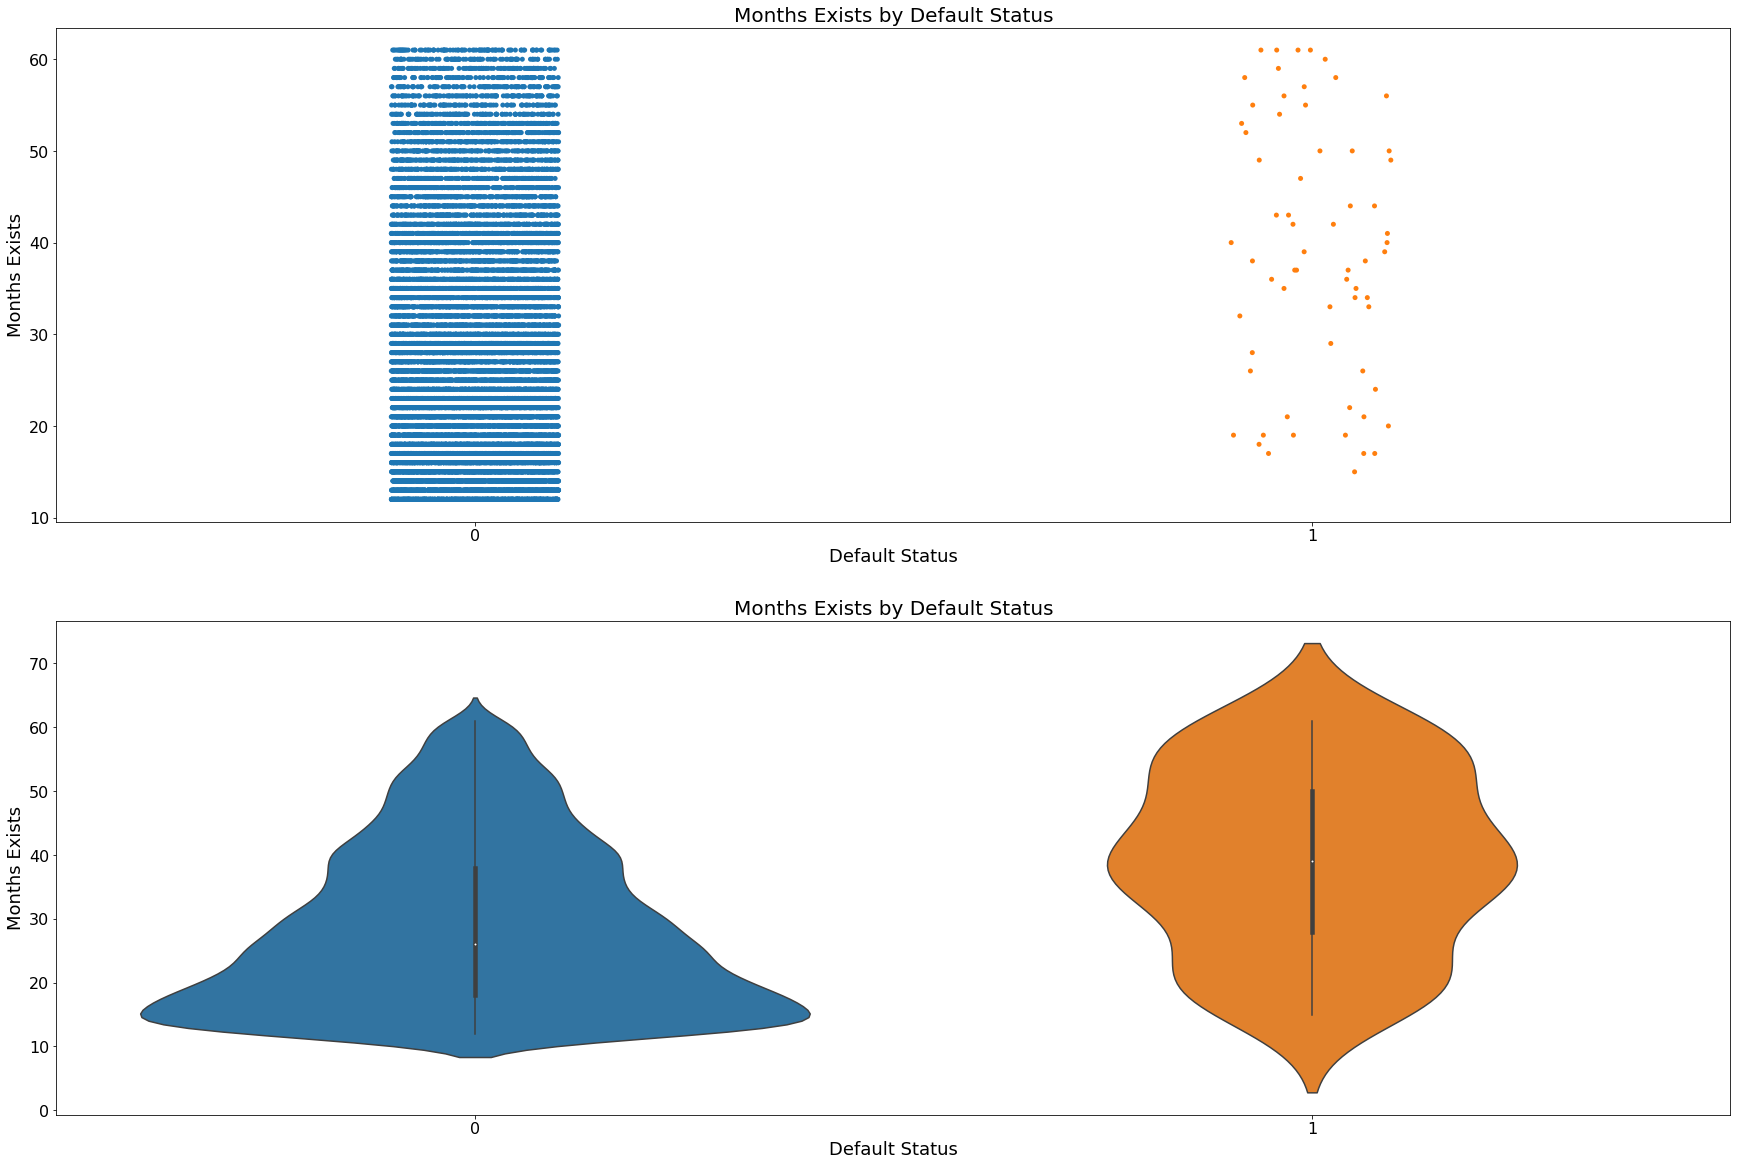

In [15]:
# Plot striplot (swarm plot wouldn't work) and violin plot pairs for all continious variables
columns = ['total_score', 'odd_months_score', 'last_half_score',
       'first_half_score', 'difference_score', 'odds_evens_score',
       'begining_score', 'middle_score', 'ending_score', 'spread_score',
       'alpha_omgea_score', 'begining_ending_score', 'months_exist']
# create a label list for xtics
labels = ['Total Score', 'Odd Months Score', 'Last Half Score', 'First Half Score', 'Difference Score', 'Odds & Evens Score', 'Begining Score', 'Middle Score', 'Ending Score', 'Spread Score', 'Alpha & Omgea Score', 'Begining & Ending Score', 'Months Exists']

for col, label in zip(columns, labels):
    plt.figure(figsize=(30,20))
    plt.subplot(211)
    sns.stripplot(data=train, x='defaulted', y=col)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Default Status', fontsize=18)
    plt.ylabel(label, fontsize=18)
    plt.title(f'{label} by Default Status', fontsize=20)
    plt.subplot(212)
    sns.violinplot(data=train, x='defaulted', y=col)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Default Status', fontsize=18)
    plt.ylabel(label, fontsize=18)
    plt.title(f'{label} by Default Status', fontsize=20)

### Categorical Variables

> 'name_income_type', 'name_education_type', 'name_housing_type'

---
**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

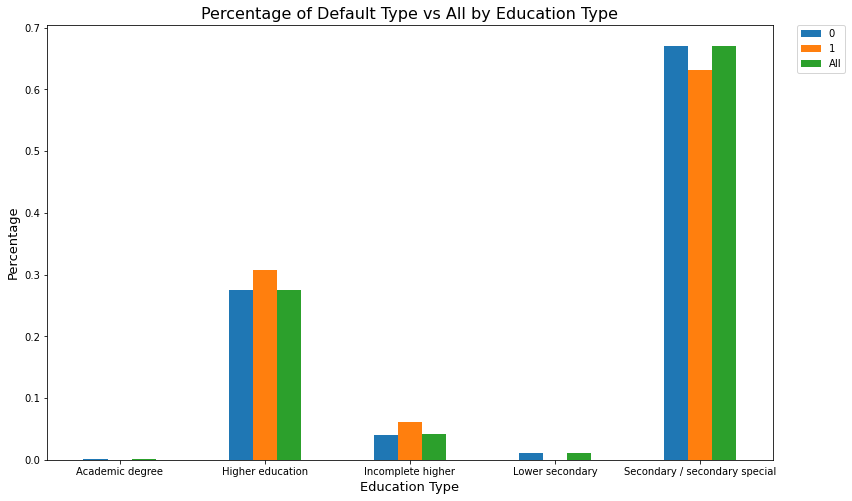

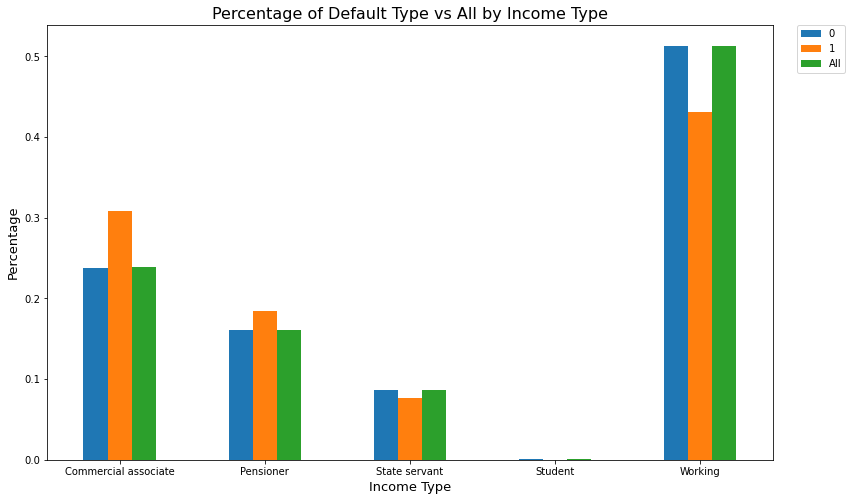

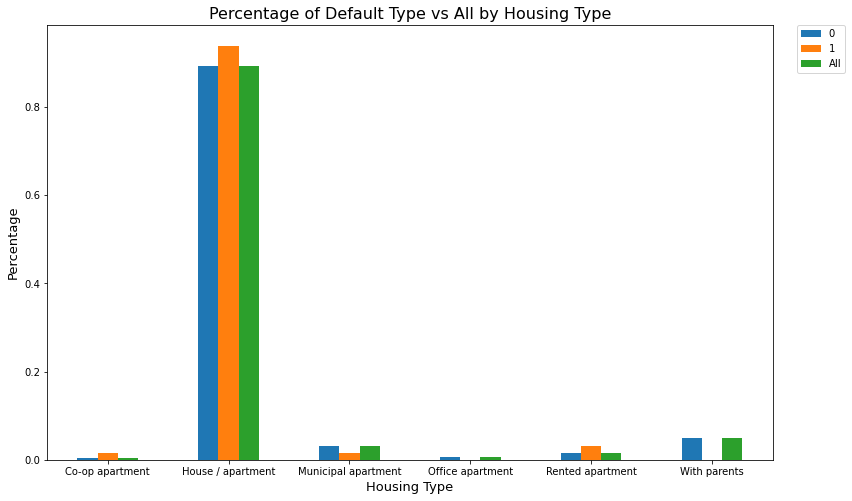

In [16]:
pd.crosstab(train.name_education_type, train.defaulted, margins = True, normalize = 'columns').plot(kind = 'bar',
                                                                                                   figsize=(13,8),
                                                                                                   rot=0)
plt.xlabel("Education Type", fontsize=13)
plt.ylabel("Percentage", fontsize=13)
plt.title("Percentage of Default Type vs All by Education Type", fontsize=16)
plt.legend(bbox_to_anchor=(1.1, 1),borderaxespad=0)
pd.crosstab(train.name_income_type, train.defaulted, margins = True, normalize = 'columns').plot(kind = 'bar',
                                                                                                figsize=(13,8),
                                                                                                rot=0)
plt.xlabel("Income Type", fontsize=13)
plt.ylabel("Percentage", fontsize=13)
plt.title("Percentage of Default Type vs All by Income Type", fontsize=16)
plt.legend(bbox_to_anchor=(1.1, 1),borderaxespad=0)
pd.crosstab(train.name_housing_type, train.defaulted, margins = True, normalize = 'columns').plot(kind = 'bar',
                                                                                                 figsize=(13,8),
                                                                                                 rot=0)
plt.xlabel("Housing Type", fontsize=13)
plt.ylabel("Percentage", fontsize=13)
plt.title("Percentage of Default Type vs All by Housing Type", fontsize=16)
plt.legend(bbox_to_anchor=(1.1, 1),borderaxespad=0)

## Hypothesis Testing

To test for statistical significance we need to run [chi squared tests](#Chi-Squared-Test) on our categorical variables and [Two Sample; Two-Tail T-test](#T-Test) on our continuous variables since our target variable, defaulted, is a categorical variable. From these test we failed to reject the null hypothesis on all our test involving categorical variables meaning that we could not prove statistical significance. On the other hand, we could did reject the null hypothesis on all our test involving our continuous variables and thus we can use them to build our models.

---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

### Chi Squared Test

In [17]:
# lets run some chi2 test on these

cols_to_run = ['name_income_type', 'name_education_type', 'name_housing_type']



# def run_chi(cols_to_run, target):
a = 0.05
for col in cols_to_run:
    observed = pd.crosstab(train['defaulted'], train[col])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    print(f'The chi^2 test results for {col} is:')
    if p < a:
        print(f'p: {p}')
        print(f'a: {a}')
        print(f'chi2: {chi2}')
        print('The p value is less that alpha so we reject the null hypothesis')
    else:
        print(f'p: {p}')
        print(f'a: {a}')
        print(f'chi2: {chi2}')
        print('The p value is greater that alpha so we fail to reject the null hypothesis')
    print()
        

The chi^2 test results for name_income_type is:
p: 0.646818107596177
a: 0.05
chi2: 2.487820129558177
The p value is greater that alpha so we fail to reject the null hypothesis

The chi^2 test results for name_education_type is:
p: 0.7573740060768883
a: 0.05
chi2: 1.8824182429158194
The p value is greater that alpha so we fail to reject the null hypothesis

The chi^2 test results for name_housing_type is:
p: 0.21180075577247065
a: 0.05
chi2: 7.120931139081108
The p value is greater that alpha so we fail to reject the null hypothesis



### T-Test

In [18]:
cols_to_run = ['total_score', 'odd_months_score', 'last_half_score',
       'first_half_score', 'difference_score', 'odds_evens_score',
       'begining_score', 'middle_score', 'ending_score', 'spread_score',
       'alpha_omgea_score', 'begining_ending_score', 'defaulted']

a = 0.05
for col, label in zip(cols_to_run, labels):
    x1 = train[train.defaulted == 0][col]
    x2 = train[train.defaulted == 1][col]
    t, p = stats.ttest_ind(x1, x2)
    print(f'The Two-Sample; Two-Tail T-test results for {label} is:\np={p}')
    if p < a:
        print('The p value is less that alpha so we reject the null hypothesis')
    else:
        print('The p value is greater that alpha so we fail to reject the null hypothesis')
    print()

The Two-Sample; Two-Tail T-test results for Total Score is:
p=8.343123062665012e-22
The p value is less that alpha so we reject the null hypothesis

The Two-Sample; Two-Tail T-test results for Odd Months Score is:
p=2.6089833276386353e-16
The p value is less that alpha so we reject the null hypothesis

The Two-Sample; Two-Tail T-test results for Last Half Score is:
p=1.7009109600180837e-29
The p value is less that alpha so we reject the null hypothesis

The Two-Sample; Two-Tail T-test results for First Half Score is:
p=4.221197542811708e-13
The p value is less that alpha so we reject the null hypothesis

The Two-Sample; Two-Tail T-test results for Difference Score is:
p=8.07531000663316e-11
The p value is less that alpha so we reject the null hypothesis

The Two-Sample; Two-Tail T-test results for Odds & Evens Score is:
p=1.2707110765981452e-21
The p value is less that alpha so we reject the null hypothesis

The Two-Sample; Two-Tail T-test results for Begining Score is:
p=1.49051049810

# Modeling

***Explain the models created here***

---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

In [19]:
# Before scaling, we will have to drop the columns that we will not be using like id, days_birth age, etc
cols_to_drop = ['id', 'code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children','name_income_type', 'name_education_type',
       'name_family_status', 'name_housing_type', 'days_birth',
       'days_employed', 'flag_mobil', 'flag_work_phone', 'flag_phone',
       'flag_email', 'occupation_type', 'cnt_fam_members', 'employed_years',
       'age', 'name_income_type_commercial_associate',
       'name_income_type_pensioner', 'name_income_type_state_servant',
       'name_income_type_student', 'name_income_type_working',
       'name_education_type_academic_degree',
       'name_education_type_higher_education',
       'name_education_type_incomplete_higher',
       'name_education_type_lower_secondary',
       'name_education_type_secondary_/_secondary_special',
       'name_housing_type_co-op_apartment',
       'name_housing_type_house_/_apartment',
       'name_housing_type_municipal_apartment',
       'name_housing_type_office_apartment',
       'name_housing_type_rented_apartment', 'name_housing_type_with_parents',
       'occupation_type_accountants', 'occupation_type_cleaning_staff',
       'occupation_type_cooking_staff', 'occupation_type_core_staff',
       'occupation_type_drivers', 'occupation_type_hr_staff',
       'occupation_type_high_skill_tech_staff', 'occupation_type_it_staff',
       'occupation_type_laborers', 'occupation_type_low-skill_laborers',
       'occupation_type_managers', 'occupation_type_medicine_staff',
       'occupation_type_other', 'occupation_type_private_service_staff',
       'occupation_type_realty_agents', 'occupation_type_sales_staff',
       'occupation_type_secretaries', 'occupation_type_security_staff',
       'occupation_type_waiters/barmen_staff']


# drop the columns from each of our datasets
train = train.drop(columns = cols_to_drop)
validate = validate.drop(columns = cols_to_drop)
test = test.drop(columns = cols_to_drop)

# use create_scaled_x_y function within the wranglev2 moduel to scale each of our DFs
X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test = create_scaled_x_y(train, validate, test, 'defaulted')



In [20]:
# create the over sampling object We'll over sample the minority by 10%
over = SMOTE(sampling_strategy=0.3)
# create the undersampling object. We'll undersample to having 60% more than the minority class
under = RandomUnderSampler(sampling_strategy=0.7)
# create the imbalance learn pipline objects where o is over and u is under for step
steps = [('o', over), ('u', under)]
# assigns stes to steps in a pipeline object
pipeline = Pipeline(steps=steps)

# fit resampling pipeline to the training data set
X_train_scaled_overunder, y_train_overunder = pipeline.fit_resample(X_train_scaled, y_train)

# print the shapes
print(f"original:{train.shape[0]} New X:{X_train_scaled.shape[0]} New Y:{y_train.shape[0]}")


original:17633 New X:17633 New Y:17633


In [21]:
train.columns

Index(['amt_income_total', '0-29', '30-59', '60-89', '90-119', '120-149',
       'paid_off', 'no_debt', 'months_exist', 'month_01', 'month_02',
       'month_03', 'month_04', 'month_05', 'month_06', 'total_score',
       'odd_months_score', 'last_half_score', 'first_half_score',
       'difference_score', 'odds_evens_score', 'begining_score',
       'middle_score', 'ending_score', 'spread_score', 'alpha_omgea_score',
       'begining_ending_score', 'defaulted'],
      dtype='object')

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,  recall_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier

# use x_var and y_var created by using both undersampling the majority class and oversampling the minority class

model_features = ['amt_income_total', 'paid_off', 'no_debt', 'total_score']

#LOGISTIC REGRESSION

# create our model object
logit = LogisticRegression(C = .1, random_state = 123)

# fitting the model object
logit = logit.fit(X_train_scaled_overunder[model_features], y_train_overunder)

#predicting with the model object
y_train_overunder_pred = logit.predict(X_train_scaled_overunder[model_features])

#calculating classification report
print(classification_report(y_train_overunder, y_train_overunder_pred))
print()

#We want to know how well the model can specifically classify bad loans, since they’re more important. 
#In statistics, this is called **recall**, and it’s the number of correctly predicted “positives” divided by 
#the total number of “positives”.
accuracy = logit.score(X_train_scaled_overunder[model_features], y_train_overunder)
recall = recall_score(y_train_overunder, y_train_overunder_pred )

print(f'The recall score for the logit model is: {recall}')

              precision    recall  f1-score   support

           0       0.89      0.73      0.80      7528
           1       0.69      0.87      0.77      5270

    accuracy                           0.79     12798
   macro avg       0.79      0.80      0.79     12798
weighted avg       0.81      0.79      0.79     12798


The recall score for the logit model is: 0.8666034155597723


# Validate

In [25]:
y_val_overunder_pred = logit.predict(X_validate_scaled[model_features])


print(classification_report(y_validate, y_val_over_under_pred))
print()
accuracy = logit.score(X_validate_scaled[model_features],  y_val_over_under_pred)
recall = recall_score(y_validate, y_val_overunder_pred )

print(f'The recall score for the Logit is: {recall}')

              precision    recall  f1-score   support

           0       1.00      0.73      0.84      4393
           1       0.01      1.00      0.03        16

    accuracy                           0.73      4409
   macro avg       0.51      0.86      0.43      4409
weighted avg       1.00      0.73      0.84      4409


The recall score for the Logit is: 1.0


# Test

In [26]:
y_test_overunder_pred = logit.predict(X_test_scaled[model_features])


print(classification_report(y_test, y_test_overunder_pred))
print()
accuracy = logit.score(X_test_scaled[model_features],  y_test_overunder_pred)
recall = recall_score(y_test, y_test_overunder_pred )

print(f'The recall score for the Logit is: {recall}')

              precision    recall  f1-score   support

           0       1.00      0.72      0.84      2441
           1       0.01      0.78      0.02         9

    accuracy                           0.72      2450
   macro avg       0.50      0.75      0.43      2450
weighted avg       1.00      0.72      0.84      2450


The recall score for the Logit is: 0.7777777777777778


# Results and Conclusions

***Explain the results from modeling minus the test here**

---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

In [ ]:
# Cell for running test model

***how did the model perform on test***

## Next Steps

***Next steps here***


---


**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)

# Appendix


---

**Jump-to:** [Table of Contents](#Table-of-Contents) | [Goal](#Goal) | [Wrangle](#Wrangle) | [EDA](#EDA) | [Gender](#Gender) | [Visualizations](#Visualizations) | [Insightful](#Insightful-Visualizations) | [Hypothesis Testing](#Hypothesis-Testing) | [Modeling](#Modeling) | [Results and Conclusions](#Results-and-Conclusions) | [Next Steps](#Next-Steps) | [Appendix](#Appendix)